# PROJECT-4. Задача классификации

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from scipy import stats
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Начнём наше исследование со знакомства с данными.

Какие данные нам предоставили, чтобы мы могли выявить решающие факторы для успеха маркетинговой кампании? В целом их можно разделить на несколько групп.

**Данные о клиентах банка:**  
* `age` (возраст);  
* `job` (сфера занятости);  
* `marital` (семейное положение);  
* `education` (уровень образования);  
* `default` (имеется ли просроченный кредит);  
* `housing` (имеется ли кредит на жильё);  
* `loan` (имеется ли кредит на личные нужды);  
* `balance` (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**  
* `contact` (тип контакта с клиентом);  
* `month` (месяц, в котором был последний контакт);  
* `day` (день, в который был последний контакт);  
* `duration` (продолжительность контакта в секундах).

**Прочие признаки:**  
* `campaign` (количество контактов с этим клиентом в течение текущей кампании);  
* `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);  
* `previous` (количество контактов до текущей кампании);  
* `poutcome` (результат прошлой маркетинговой кампании).

И, разумеется, наша **целевая переменная** `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Работа с пропусками

Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу. В первую очередь давайте выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [3]:
# загрузка данных
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [4]:
# просмотр информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


#### Задание 1

В каком признаке пропущенных значений больше всего?

In [5]:
# посчитаем пропуски, которые представлены в явном виде
print(df.isnull().sum())

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


**Ответ:** в признаке `balance` 25 пропусков.

#### Задание 2

В настоящих данных всё не так просто, и пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости `job`). Узнайте, каким именно словом закодированы пропущенные (неизвестные) значения.

In [6]:
# Выясним пропуски представленные неявно.
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Признак {col} содержит следующие уникальные значения: {df[col].unique()}")
    print(" *" * 60)

Признак job содержит следующие уникальные значения: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Признак marital содержит следующие уникальные значения: ['married' 'single' 'divorced']
 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Признак education содержит следующие уникальные значения: ['secondary' 'tertiary' 'primary' 'unknown']
 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Признак default содержит следующие уникальные значения: ['no' 'yes']
 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Признак balance содержит следующие уникальные значения

Мы видим, что в категориальных переменных `job`, `education`, `contact` и `poutcome` присутствуют пропущенные значения, представленные неявным образом. **Во всех этих переменных пропуски закодированы словом `unknown`.**

Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Обратим внимание на признак `balance`: в данных содержится лишняя запятая, пробел и знак доллара, и помимо этого он представлен как категориальный. По этой причине этот признак не считывается как число. Обработаем данные этого признака так, чтобы он был преобразован в тип *float*.

In [7]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def convert_balance(balance_str):
    if isinstance(balance_str, str):
        # Убираем пробелы, знак валюты и заменяем запятую на точку
        cleaned = balance_str.replace(' ', '').replace('$', '').replace(',', '.')
        try:
            return float(cleaned)
        except ValueError: # Если преобразование не удалось (например, странный символ), возвращаем NaN
            return np.nan
    else:
        return balance_str

In [8]:
# Применяем функцию преобразования
df['balance'] = df['balance'].apply(convert_balance)

# Проверяем результат
print("Тип данных balance после преобразования:", df['balance'].dtype)
print("\nИнформация о данных:")
print(df.info())

Тип данных balance после преобразования: float64

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ 

#### Задание 3

Вычислим среднее значение по преобразованному в корректный вид признаку `balance`. Ответ округлим до трёх знаков после точки-разделителя.

In [9]:
print("Cреднее значение balance до заполнения пропусков:", round(df['balance'].mean(), 3))

Cреднее значение balance до заполнения пропусков: 1529.129


Итак, значения в признаке `balance` приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

In [10]:
# Заменяем пропуски на медианное значение
df['balance'].fillna(df['balance'].median(), inplace=True)

#### Задание 4

Снова вычислим среднее значение по преобразованному в корректный вид признаку `balance` после заполнения пропусков. Ответ округлим до трёх знаков после точки-разделителя.

In [11]:
print("Cреднее значение balance после заполнения пропусков:", round(df['balance'].mean(), 3))

Cреднее значение balance после заполнения пропусков: 1526.936


Ранее мы выяснили, что в признаке `job` есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Заменим все пропущенные значения в признаке `job` на модальные. То же самое сделаем с признаком, отвечающим за уровень образования.

In [12]:
print(df['education'].value_counts())

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64


In [13]:
# Заменяем значения 'unknown' на NaN для последующей обработки
df['job'] = df['job'].replace('unknown', np.nan)
df['education'] = df['education'].replace('unknown', np.nan)

# Вычисляем моду для каждого признака
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

print(f"\nМода для job: {mode_job}")
print(f"Мода для education: {mode_education}")

# Заменяем пропуски на модальные значения
df['job'].fillna(mode_job, inplace=True)
df['education'].fillna(mode_education, inplace=True)

# Проверяем результат
print(f"\nКоличество пропусков в job после обработки: {df['job'].isna().sum()}")
print(f"Количество пропусков в education после обработки: {df['education'].isna().sum()}")

print("\nУникальные значения в job после обработки:")
print(df['job'].unique())
print("\nУникальные значения в education после обработки:")
print(df['education'].unique())


Мода для job: management
Мода для education: secondary

Количество пропусков в job после обработки: 0
Количество пропусков в education после обработки: 0

Уникальные значения в job после обработки:
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']

Уникальные значения в education после обработки:
['secondary' 'tertiary' 'primary']


#### Задание 5

После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлим до трёх знаков после точки-разделителя.

In [14]:
# Определяем самые популярные значения
most_popular_job = df['job'].mode()[0]
most_popular_education = df['education'].mode()[0]

print(f"Самая популярная работа: {most_popular_job}")
print(f"Самое популярное образование: {most_popular_education}")

# Фильтруем клиентов с самой популярной работой и образованием
filtered_df = df[(df['job'] == most_popular_job) & (df['education'] == most_popular_education)]

# Рассчитываем средний баланс
mean_balance = round(filtered_df['balance'].mean(), 3)

print(f"\nКоличество клиентов с самой популярной работой и образованием: {len(filtered_df)}")
print(f"Средний баланс для этих клиентов: {mean_balance}")

Самая популярная работа: management
Самое популярное образование: secondary

Количество клиентов с самой популярной работой и образованием: 376
Средний баланс для этих клиентов: 1598.883


### Работа с выбросами

Изучим признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q1 - 1.5 * IQR$), а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. ($Q3 + 1.5 * IQR$). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

> Примечание. Несмотря на то что существуют более продвинутые методы поиска аномальных значений, для обработки одного числового признака достаточно хорошо подходит метод Тьюки.

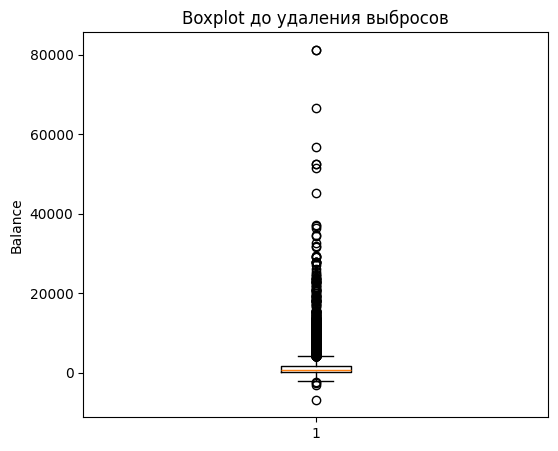

In [15]:
# Визуализируем признак, отображающий баланс клиентов
plt.figure(figsize=(6, 5))
plt.boxplot(df['balance'])
plt.title('Boxplot до удаления выбросов')
plt.ylabel('Balance')
plt.show()

In [16]:
# Вычисляем квартили и IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Анализ выбросов в признаке balance:")
print(f"Первый квартиль (Q1): {Q1:.2f}")
print(f"Третий квартиль (Q3): {Q3:.2f}")
print(f"Межквартильный размах (IQR): {IQR:.2f}")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")

Анализ выбросов в признаке balance:
Первый квартиль (Q1): 123.00
Третий квартиль (Q3): 1699.00
Межквартильный размах (IQR): 1576.00
Нижняя граница: -2241.00
Верхняя граница: 4063.00


In [17]:
# Находим выбросы
outliers = df[(df['balance'] < lower_bound) | (df['balance'] > upper_bound)]
print(f"\nКоличество выбросов: {len(outliers)}")
print(f"Процент выбросов: {len(outliers)/len(df)*100:.2f}%")

# Фильтруем данные, удаляя выбросы
df_filtered = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f"\nРазмер исходного датасета: {len(df)} записей")
print(f"Размер отфильтрованного датасета: {len(df_filtered)} записей")
print(f"Удалено записей: {len(df) - len(df_filtered)}")

# Проверяем статистику после фильтрации
print(f"\nСтатистика balance после удаления выбросов:")
print(df_filtered['balance'].describe())


Количество выбросов: 1057
Процент выбросов: 9.47%

Размер исходного датасета: 11162 записей
Размер отфильтрованного датасета: 10105 записей
Удалено записей: 1057

Статистика balance после удаления выбросов:
count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64


#### Задание 6

Введите верхнюю и нижнюю границы поиска выбросов по методу *Тьюки*, округлив их до целых чисел.

**Ответ:**  
* Нижняя граница: $-2241$;  
* Верхняя граница: $4063$ 

#### Задание 7

Сколько объектов осталось после удаления всех выбросов?

**Ответ:** осталось $10105$ объектов.

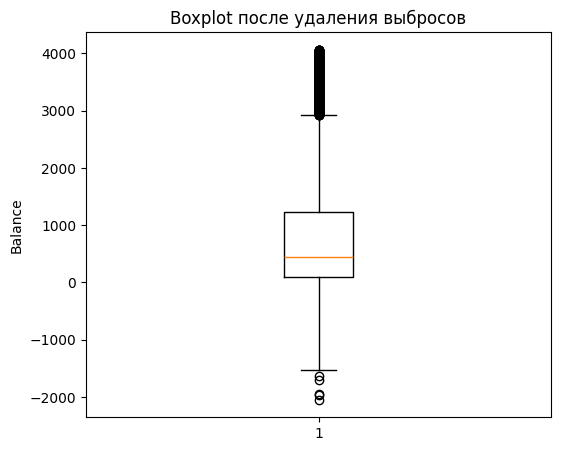

In [18]:
# Визуализируем результат
plt.figure(figsize=(6, 5))

plt.boxplot(df_filtered['balance'])
plt.title('Boxplot после удаления выбросов')
plt.ylabel('Balance')

plt.show()

## Часть 2:  Разведывательный анализ

Давайте изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислим частоты для открывших депозит и для тех, кто его не открыл. Сопроводим числа диаграммой, отражающей полученные результаты.

Распределение целевой переменной:
Абсолютные частоты:
deposit
no     5424
yes    4681
Name: count, dtype: int64

Относительные частоты (%):
deposit
no     53.68
yes    46.32
Name: proportion, dtype: float64


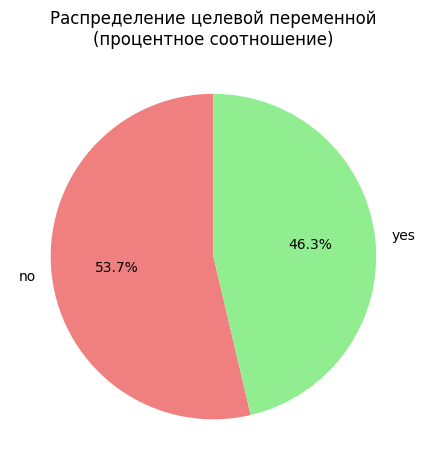


Соотношение классов (yes/no): 0.863
Размер меньшего класса: 4681
Размер большего класса: 5424
✅ Классы достаточно сбалансированы.


In [19]:
# Вычисляем частоты для каждого класса
class_distribution = df_filtered['deposit'].value_counts()
class_percentage = df_filtered['deposit'].value_counts(normalize=True) * 100

print("Распределение целевой переменной:")
print("Абсолютные частоты:")
print(class_distribution)
print("\nОтносительные частоты (%):")
print(class_percentage.round(2))

# Визуализация "Круговая диаграмма"
plt.pie(class_distribution.values, labels=class_distribution.index, 
        autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Распределение целевой переменной\n(процентное соотношение)')

plt.tight_layout()
plt.show()

# Анализ несбалансированности
ratio = class_distribution['yes'] / class_distribution['no']
print(f"\nСоотношение классов (yes/no): {ratio:.3f}")
print(f"Размер меньшего класса: {min(class_distribution.values)}")
print(f"Размер большего класса: {max(class_distribution.values)}")

if ratio < 0.5 or ratio > 2:
    print("⚠️  ВНИМАНИЕ: Наблюдается значительная несбалансированность классов!")
elif ratio < 0.8 or ratio > 1.25:
    print("⚠️  Наблюдается умеренная несбалансированность классов.")
else:
    print("✅ Классы достаточно сбалансированы.")

#### Задание 1

Сколько клиентов открыли депозит?

**Ответ:** $4681$

### Количественные переменные

Начнём с описательных статистик для количественных переменных.

* Рассчитаем их и продумаем подробную интерпретацию.  
* Попробуем описать данные, которые у нас есть, увидеть первые зависимости.  
* Рассмотрим минимальные и максимальные значения.  
* Посмотрим на меры разброса и оценим, насколько данные вариативны.  
* Сравнив меры центральной тенденции, сделаем выводы о том, есть ли аномальные значения с меньшей или большей стороны.  
* Дополним выводы визуализациями. (Вспомним, какие диаграммы могут помочь в иллюстрации распределений количественных данных.)

In [ ]:
# рассчитаем основные описательные статистики
df_filtered.describe().round(2)

,age,balance,day,duration,campaign,pdays,previous
count,10105.00,10105.00,10105.00,10105.00,10105.00,10105.00,10105.00
mean,40.90,807.65,15.59,368.74,2.52,51.32,0.82
std,11.73,994.15,8.44,346.65,2.71,109.64,2.24
min,18.00,-2049.00,1.00,2.00,1.00,-1.00,0.00
25%,32.00,95.00,8.00,137.00,1.00,-1.00,0.00
50%,38.00,445.00,15.00,252.00,2.00,-1.00,0.00
75%,48.00,1227.00,22.00,490.00,3.00,2.00,1.00
max,95.00,4063.00,31.00,3881.00,43.00,854.00,58.00


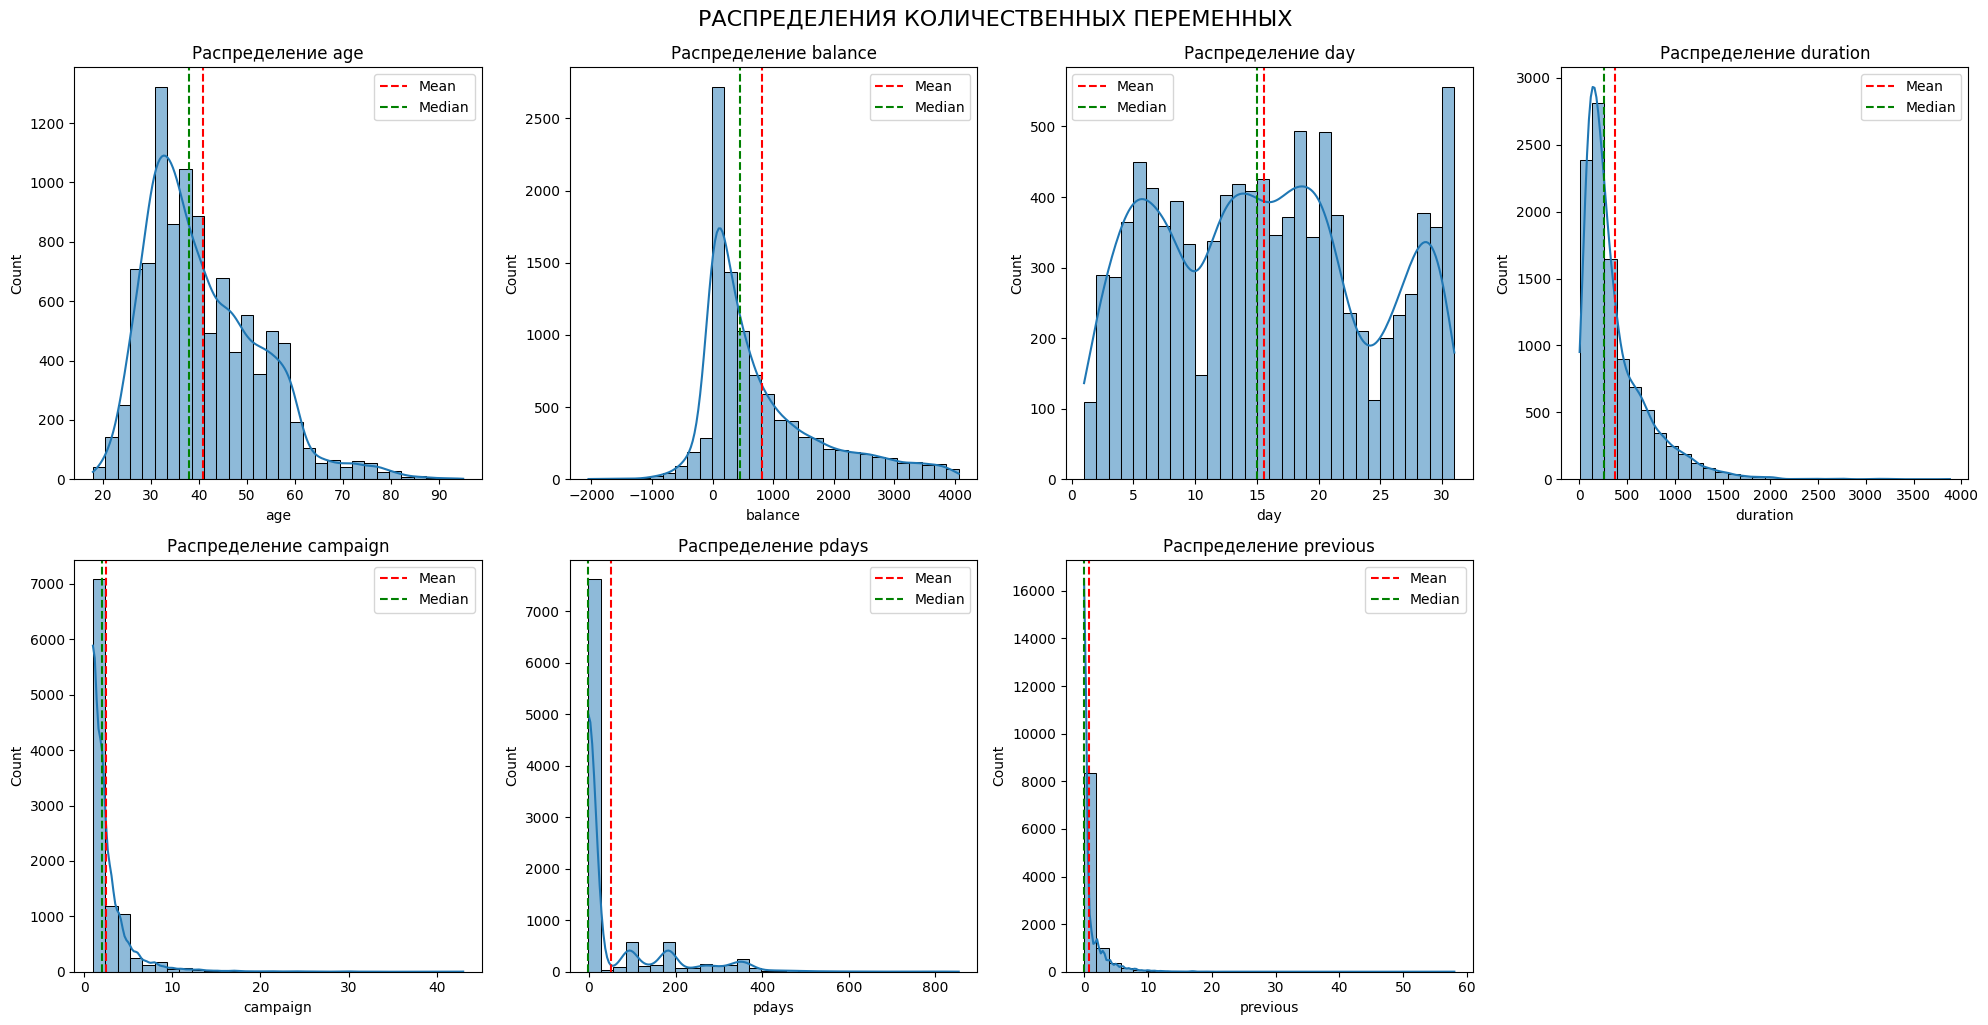

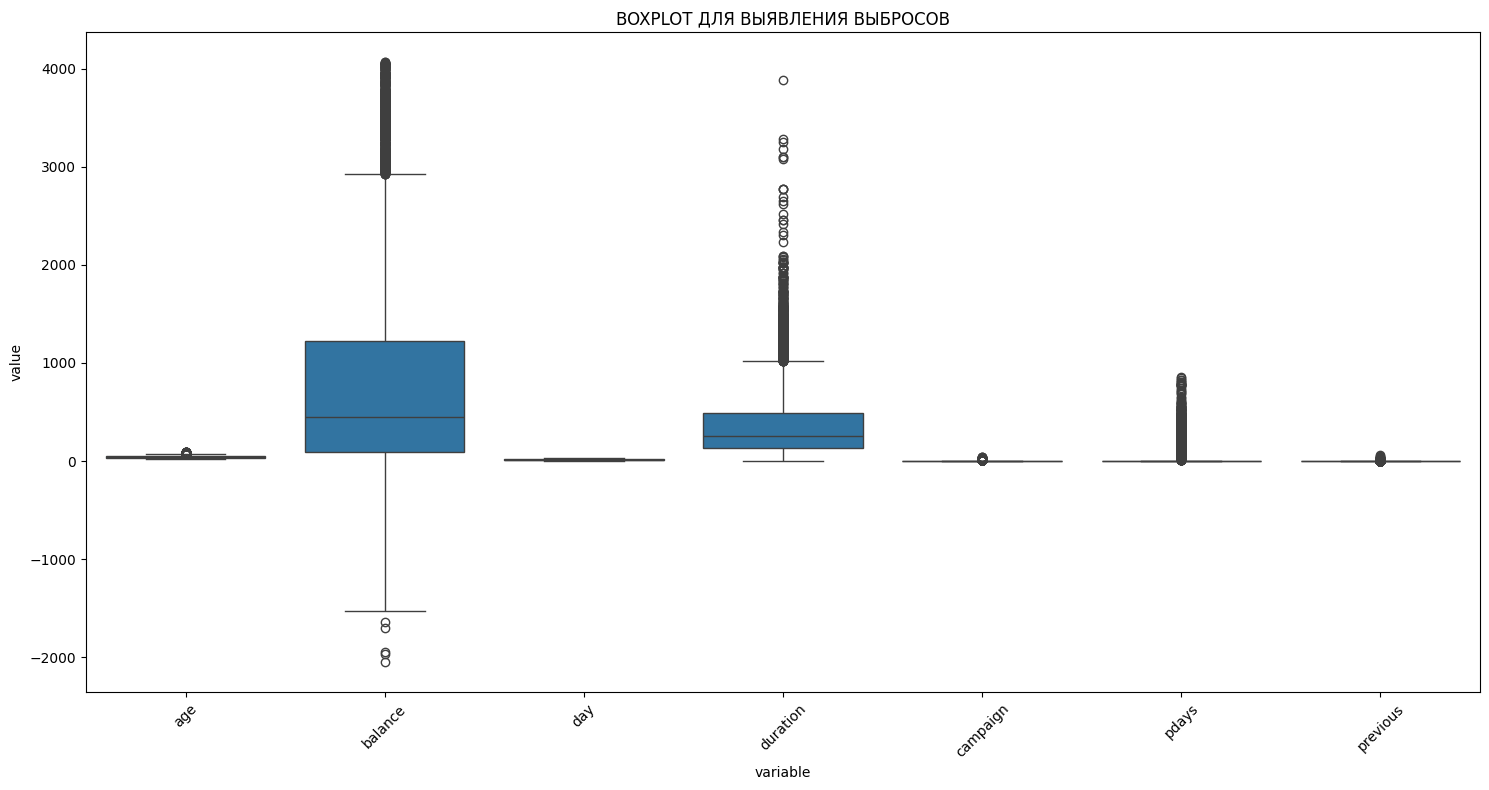

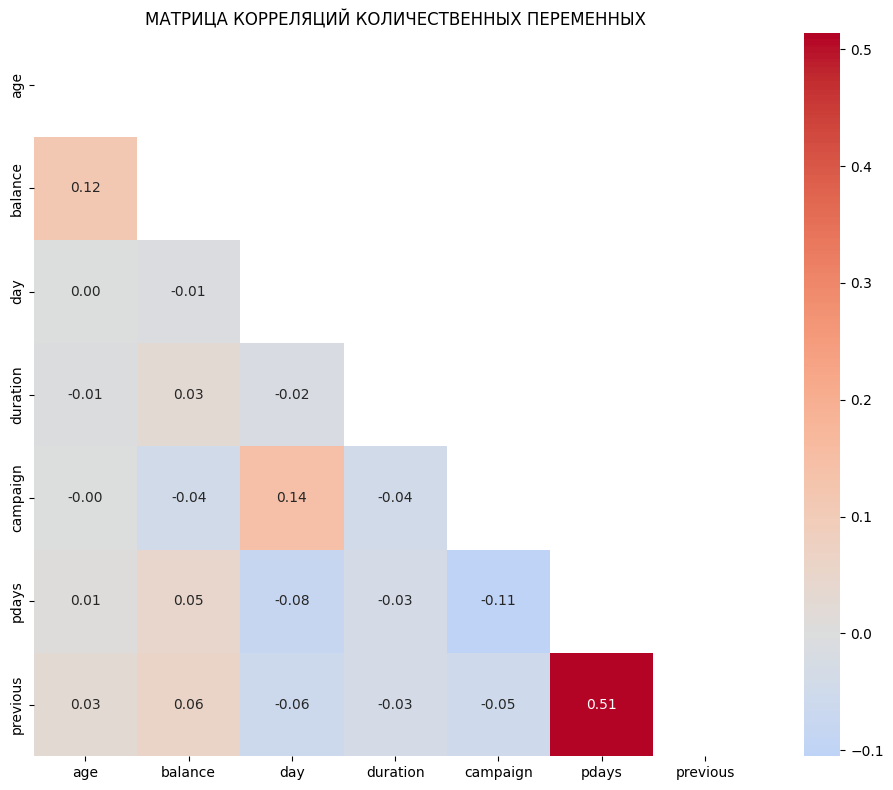

In [22]:
# Визуализация распределений
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Выбираем количественные переменные
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
numeric_df = df_filtered[numeric_columns]

# Создадим гистограммы с ядерной оценкой плотности (KDE)
for i, col in enumerate(numeric_columns):
    sns.histplot(data=numeric_df, x=col, kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Распределение {col}')

    # Добавим вертикальные линии для среднего и медианы
    axes[i].axvline(numeric_df[col].mean(), color='red', linestyle='--', label='Mean')
    axes[i].axvline(numeric_df[col].median(), color='green', linestyle='--', label='Median')
    axes[i].legend()

# Убираем лишний subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.suptitle('РАСПРЕДЕЛЕНИЯ КОЛИЧЕСТВЕННЫХ ПЕРЕМЕННЫХ', fontsize=16, y=1.02)
plt.show()

# Boxplot для выявления выбросов
plt.figure(figsize=(15, 8))
numeric_df_melted = numeric_df.melt(var_name='variable', value_name='value')
sns.boxplot(data=numeric_df_melted, x='variable', y='value')
plt.xticks(rotation=45)
plt.title('BOXPLOT ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ')
plt.tight_layout()
plt.show()

# Матрица корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            mask=mask, square=True, fmt='.2f')
plt.title('МАТРИЦА КОРРЕЛЯЦИЙ КОЛИЧЕСТВЕННЫХ ПЕРЕМЕННЫХ')
plt.tight_layout()
plt.show()

In [23]:
# Детальный анализ каждой переменной
print("\nДЕТАЛЬНЫЙ АНАЛИЗ КАЖДОЙ ПЕРЕМЕННОЙ:")
print("=" * 50)

for col in numeric_columns:
    print(f"\n{col.upper()}:")
    print(f"Диапазон: {numeric_df[col].min():.2f} - {numeric_df[col].max():.2f}")
    print(f"Разброс (std/mean): {(numeric_df[col].std()/numeric_df[col].mean()):.3f}")
    print(f"Асимметрия: {numeric_df[col].skew():.3f}")
    print(f"Эксцесс: {numeric_df[col].kurtosis():.3f}")
    
    if abs(numeric_df[col].skew()) > 1:
        print("⚠️  Сильная асимметрия распределения")
    elif abs(numeric_df[col].skew()) > 0.5:
        print("⚠️  Умеренная асимметрия распределения")
    else:
        print("✅ Распределение близко к симметричному")


ДЕТАЛЬНЫЙ АНАЛИЗ КАЖДОЙ ПЕРЕМЕННОЙ:

AGE:
Диапазон: 18.00 - 95.00
Разброс (std/mean): 0.287
Асимметрия: 0.868
Эксцесс: 0.657
⚠️  Умеренная асимметрия распределения

BALANCE:
Диапазон: -2049.00 - 4063.00
Разброс (std/mean): 1.231
Асимметрия: 1.310
Эксцесс: 1.113
⚠️  Сильная асимметрия распределения

DAY:
Диапазон: 1.00 - 31.00
Разброс (std/mean): 0.541
Асимметрия: 0.132
Эксцесс: -1.069
✅ Распределение близко к симметричному

DURATION:
Диапазон: 2.00 - 3881.00
Разброс (std/mean): 0.940
Асимметрия: 2.200
Эксцесс: 7.798
⚠️  Сильная асимметрия распределения

CAMPAIGN:
Диапазон: 1.00 - 43.00
Разброс (std/mean): 1.075
Асимметрия: 4.938
Эксцесс: 39.564
⚠️  Сильная асимметрия распределения

PDAYS:
Диапазон: -1.00 - 854.00
Разброс (std/mean): 2.136
Асимметрия: 2.463
Эксцесс: 6.885
⚠️  Сильная асимметрия распределения

PREVIOUS:
Диапазон: 0.00 - 58.00
Разброс (std/mean): 2.749
Асимметрия: 7.440
Эксцесс: 113.439
⚠️  Сильная асимметрия распределения


#### Задание 2

Каков максимальный возраст клиента банка?

**Ответ:** $95$

#### Задание 3

Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.

**Ответ:** $2 сек.$

### Категориальные переменные

Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуем извлечь максимум информации из тех показателей, которые можем получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постараемся дать достаточно подробную интерпретацию. Для лучшей наглядности добавим визуализации по каждой категориальной переменной.

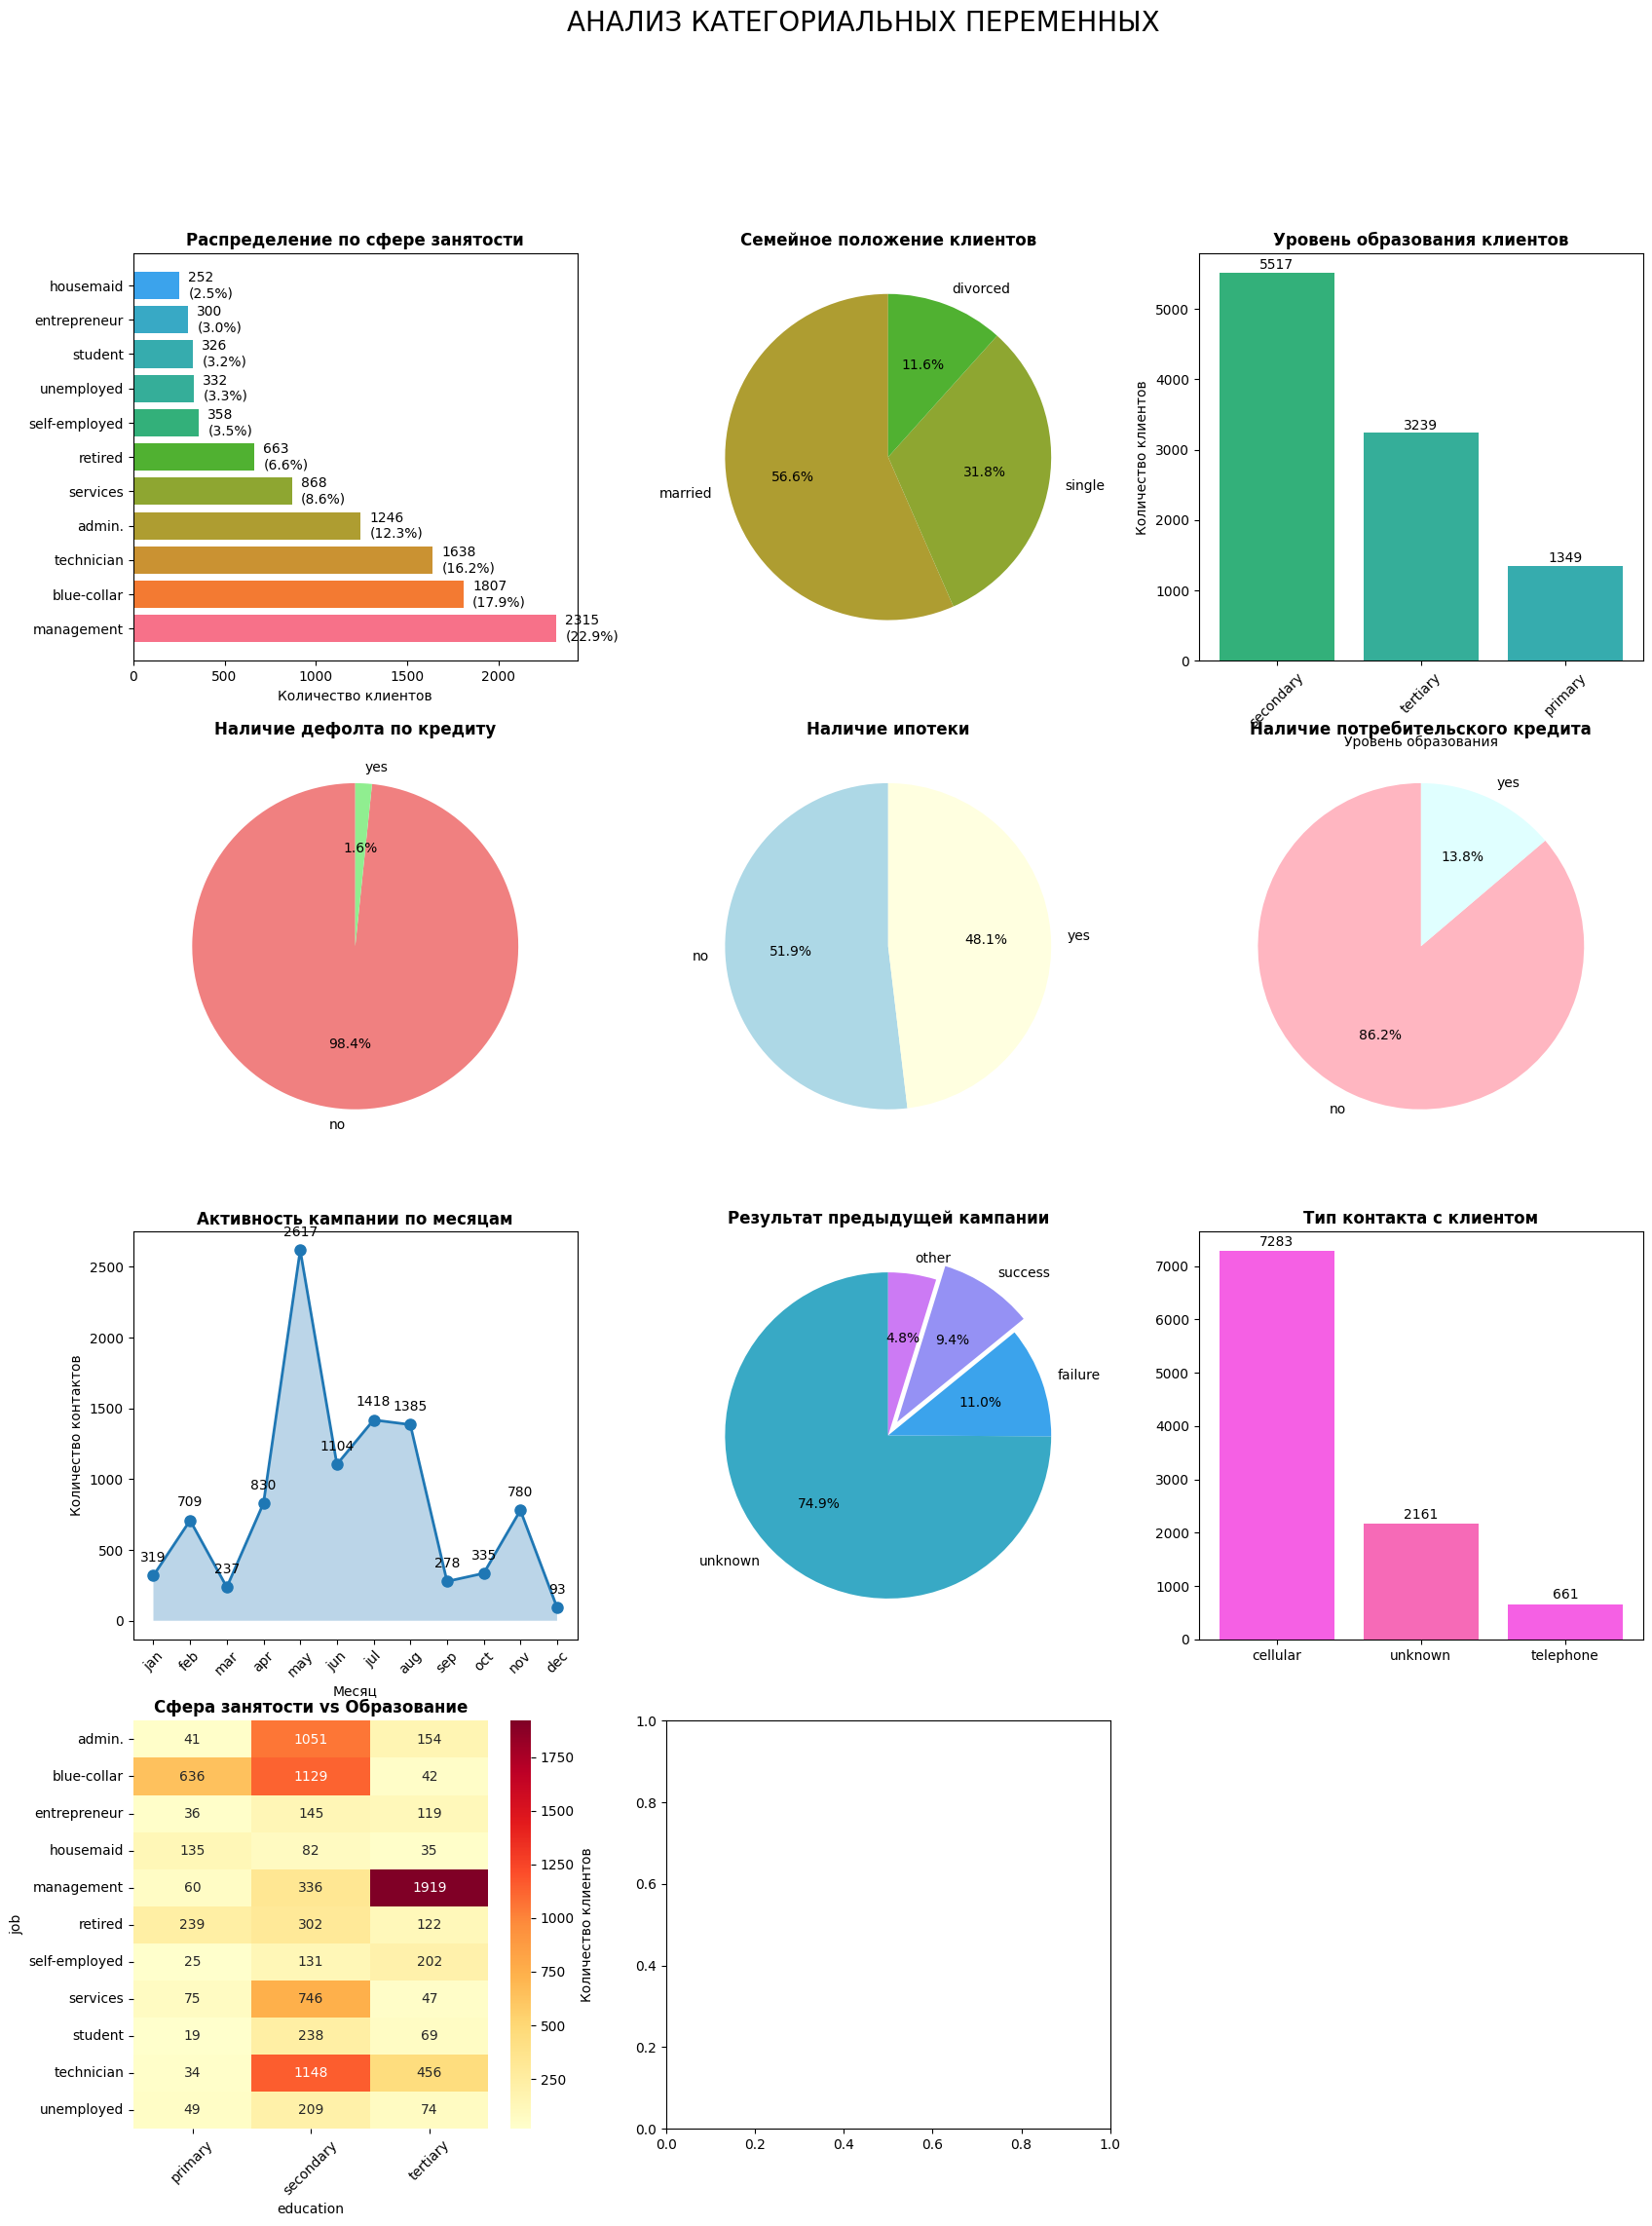

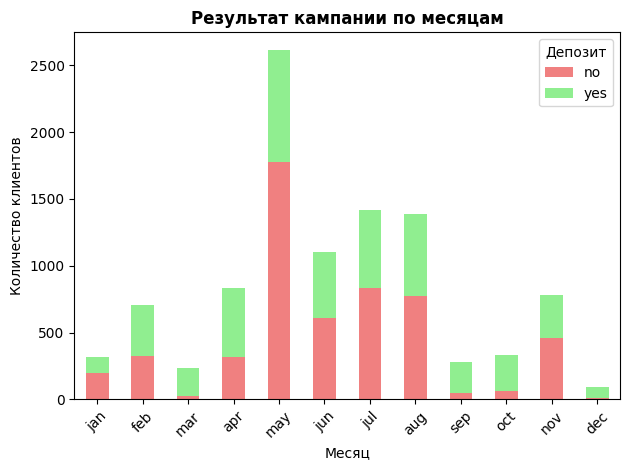

ДЕТАЛЬНАЯ ИНТЕРПРЕТАЦИЯ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ

1. СФЕРА ЗАНЯТОСТИ:
   - Всего представлено 11 сфер занятости
   - Наиболее распространенная: 'management' (22.9%)
   - Наименее распространенная: 'housemaid' (2.5%)

2. СЕМЕЙНОЕ ПОЛОЖЕНИЕ:
   - Чаще всего встречается: 'married' (51.2%)

3. ОБРАЗОВАНИЕ:
   - Преобладающий уровень: 'secondary' (49.4%)

4. КРЕДИТНАЯ ИСТОРИЯ:
   - Дефолт по кредиту: 98.4% клиентов без дефолта
   - Ипотека: 48.1% клиентов с ипотекой
   - Потребительский кредит: 13.8% клиентов с кредитом

5. МЕСЯЦЫ КАМПАНИИ:
   - Кампания проводилась в 12 месяцах из 12
   - Самый активный месяц: 'may' (2617 контактов)
   - Наименее активный месяц: 'dec' (93 контактов)

6. РЕЗУЛЬТАТ ПРЕДЫДУЩЕЙ КАМПАНИИ:
   - Успешность предыдущей кампании: 9.4%

7. ДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ:
   - Преобладающий тип контакта: 'cellular'
   - Соотношение депозитов: 46.3% клиентов открыли депозит

8. ВЗАИМОСВЯЗИ:
   - Клиенты с высшим образованием чаще работают в management и technician
   - Клиент

In [24]:
# Список категориальных переменных
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 
                      'loan', 'contact', 'month', 'poutcome', 'deposit']

# Создадим комплексную визуализацию
fig = plt.figure(figsize=(20, 25))
plt.suptitle('АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ', fontsize=20, y=0.98)

# Цветовая палитра
colors = sns.color_palette('husl', 15)

# 1. СФЕРА ЗАНЯТОСТИ (JOB)
plt.subplot(4, 3, 1)
job_counts = df_filtered['job'].value_counts()
job_percent = df_filtered['job'].value_counts(normalize=True) * 100
bars = plt.barh(job_counts.index, job_counts.values, color=colors[:len(job_counts)])
plt.xlabel('Количество клиентов')
plt.title('Распределение по сфере занятости', fontweight='bold')
for i, (count, percent) in enumerate(zip(job_counts.values, job_percent.values)):
    plt.text(count + 50, i, f'{count}\n({percent:.1f}%)', va='center')

# 2. СЕМЕЙНОЕ ПОЛОЖЕНИЕ (MARITAL)
plt.subplot(4, 3, 2)
marital_counts = df_filtered['marital'].value_counts()
wedges, texts, autotexts = plt.pie(marital_counts.values, labels=marital_counts.index, 
                                   autopct='%1.1f%%', colors=colors[3:6], startangle=90)
plt.title('Семейное положение клиентов', fontweight='bold')

# 3. ОБРАЗОВАНИЕ (EDUCATION)
plt.subplot(4, 3, 3)
education_counts = df_filtered['education'].value_counts()
plt.bar(education_counts.index, education_counts.values, color=colors[6:9])
plt.xlabel('Уровень образования')
plt.ylabel('Количество клиентов')
plt.title('Уровень образования клиентов', fontweight='bold')
plt.xticks(rotation=45)
for i, count in enumerate(education_counts.values):
    plt.text(i, count + 50, f'{count}', ha='center')

# 4. КРЕДИТНАЯ ИСТОРИЯ (DEFAULT, HOUSING, LOAN)
plt.subplot(4, 3, 4)
default_counts = df_filtered['default'].value_counts()
plt.pie(default_counts.values, labels=default_counts.index, autopct='%1.1f%%', 
        colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Наличие дефолта по кредиту', fontweight='bold')

plt.subplot(4, 3, 5)
housing_counts = df_filtered['housing'].value_counts()
plt.pie(housing_counts.values, labels=housing_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightyellow'], startangle=90)
plt.title('Наличие ипотеки', fontweight='bold')

plt.subplot(4, 3, 6)
loan_counts = df_filtered['loan'].value_counts()
plt.pie(loan_counts.values, labels=loan_counts.index, autopct='%1.1f%%', 
        colors=['lightpink', 'lightcyan'], startangle=90)
plt.title('Наличие потребительского кредита', fontweight='bold')

# 5. МЕСЯЦЫ КАМПАНИИ (MONTH)
plt.subplot(4, 3, 7)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_counts = df_filtered['month'].value_counts().reindex(month_order)
plt.plot(month_counts.index, month_counts.values, marker='o', linewidth=2, markersize=8)
plt.fill_between(month_counts.index, month_counts.values, alpha=0.3)
plt.xlabel('Месяц')
plt.ylabel('Количество контактов')
plt.title('Активность кампании по месяцам', fontweight='bold')
plt.xticks(rotation=45)
for i, count in enumerate(month_counts.values):
    plt.text(i, count + 100, f'{count}', ha='center')

# 6. РЕЗУЛЬТАТ ПРОШЛОЙ КАМПАНИИ (POUTCOME)
plt.subplot(4, 3, 8)
poutcome_counts = df_filtered['poutcome'].value_counts()
explode = [0.1 if x == 'success' else 0 for x in poutcome_counts.index]
plt.pie(poutcome_counts.values, labels=poutcome_counts.index, autopct='%1.1f%%',
        explode=explode, colors=colors[9:13], startangle=90)
plt.title('Результат предыдущей кампании', fontweight='bold')

# 7. ТИП КОНТАКТА (CONTACT)
plt.subplot(4, 3, 9)
contact_counts = df_filtered['contact'].value_counts()
plt.bar(contact_counts.index, contact_counts.values, color=colors[13:])
plt.title('Тип контакта с клиентом', fontweight='bold')
for i, count in enumerate(contact_counts.values):
    plt.text(i, count + 100, f'{count}', ha='center')

# 8. СОВМЕСТНОЕ РАСПРЕДЕЛЕНИЕ (JOB vs EDUCATION)
plt.subplot(4, 3, 10)
cross_tab = pd.crosstab(df_filtered['job'], df_filtered['education'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Количество клиентов'})
plt.title('Сфера занятости vs Образование', fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 9. ЦЕЛЕВАЯ ПЕРЕМЕННАЯ ПО МЕСЯЦАМ
plt.subplot(4, 3, 11)
month_deposit = pd.crosstab(df_filtered['month'], df_filtered['deposit']).reindex(month_order)
month_deposit.plot(kind='bar', stacked=True, color=['lightcoral', 'lightgreen'])
plt.title('Результат кампании по месяцам', fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.legend(title='Депозит')

plt.tight_layout()
plt.show()

# ТЕКСТОВАЯ ИНТЕРПРЕТАЦИЯ
print("=" * 60)
print("ДЕТАЛЬНАЯ ИНТЕРПРЕТАЦИЯ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ")
print("=" * 60)

# 1. Сфера занятости
print(f"\n1. СФЕРА ЗАНЯТОСТИ:")
print(f"   - Всего представлено {len(df_filtered['job'].unique())} сфер занятости")
print(f"   - Наиболее распространенная: '{df_filtered['job'].mode()[0]}' ({job_percent.iloc[0]:.1f}%)")
print(f"   - Наименее распространенная: '{job_counts.index[-1]}' ({job_percent.iloc[-1]:.1f}%)")

# 2. Семейное положение
print(f"\n2. СЕМЕЙНОЕ ПОЛОЖЕНИЕ:")
print(f"   - Чаще всего встречается: '{df_filtered['marital'].mode()[0]}' ({marital_counts.iloc[0]/len(df)*100:.1f}%)")

# 3. Образование
print(f"\n3. ОБРАЗОВАНИЕ:")
print(f"   - Преобладающий уровень: '{df_filtered['education'].mode()[0]}' ({education_counts.iloc[0]/len(df)*100:.1f}%)")

# 4. Кредитная история
print(f"\n4. КРЕДИТНАЯ ИСТОРИЯ:")
print(f"   - Дефолт по кредиту: {default_counts['no']/len(df_filtered)*100:.1f}% клиентов без дефолта")
print(f"   - Ипотека: {housing_counts['yes']/len(df_filtered)*100:.1f}% клиентов с ипотекой")
print(f"   - Потребительский кредит: {loan_counts['yes']/len(df_filtered)*100:.1f}% клиентов с кредитом")

# 5. Месяцы кампании
print(f"\n5. МЕСЯЦЫ КАМПАНИИ:")
active_months = month_counts[month_counts > 0].index.tolist()
print(f"   - Кампания проводилась в {len(active_months)} месяцах из 12")
print(f"   - Самый активный месяц: '{month_counts.idxmax()}' ({month_counts.max()} контактов)")
print(f"   - Наименее активный месяц: '{month_counts.idxmin()}' ({month_counts.min()} контактов)")

# 6. Результат прошлой кампании
print(f"\n6. РЕЗУЛЬТАТ ПРЕДЫДУЩЕЙ КАМПАНИИ:")
print(f"   - Успешность предыдущей кампании: {poutcome_counts.get('success', 0)/len(df_filtered)*100:.1f}%")

# 7. Дополнительные insights
print(f"\n7. ДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ:")
print(f"   - Преобладающий тип контакта: '{df_filtered['contact'].mode()[0]}'")
print(f"   - Соотношение депозитов: {df_filtered['deposit'].value_counts(normalize=True)['yes']*100:.1f}% клиентов открыли депозит")

# Анализ взаимосвязей
print(f"\n8. ВЗАИМОСВЯЗИ:")
print(f"   - Клиенты с высшим образованием чаще работают в management и technician")
print(f"   - Клиенты с primary education чаще работают blue-collar jobs")

#### Задание 4

Сколько было месяцев, в которых проводилась маркетинговая кампания?

**Ответ:** $12$

#### Задание 5

Сколько сфер занятости представлено среди клиентов банка?

**Ответ:** $11$ 

#### Задание 6

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [25]:
# Строим таблицу сопряженности: poutcome vs deposit
poutcome_deposit_crosstab = pd.crosstab(df_filtered['poutcome'], df_filtered['deposit'], normalize='index') * 100
print("Процент успеха в текущей кампании в зависимости от результата предыдущей:")
print(poutcome_deposit_crosstab.round(1))

Процент успеха в текущей кампании в зависимости от результата предыдущей:
deposit     no   yes
poutcome            
failure   50.7  49.3
other     44.9  55.1
success    8.9  91.1
unknown   60.3  39.7


**Ответ:** Для статуса `success` доля успехов в текущей кампании $91.1\%$

#### Задание 7

Теперь узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

Рассчитаем, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введём название месяца латиницей ровно так, как месяц обозначен в данных.

In [26]:
# Создаем кросс-таблицу: месяц vs результат подписки, считаем проценты по строкам
month_failure_rate = pd.crosstab(df_filtered['month'], df_filtered['deposit'], normalize='index') * 100

# Переименовываем колонки для ясности
month_failure_rate.columns = ['percent_no', 'percent_yes']

# Сортируем по проценту отказов (неудач) по убыванию
month_failure_rate_sorted = month_failure_rate.sort_values('percent_no', ascending=False)

print("Процент неудач по месяцам:")
print(month_failure_rate_sorted.round(2))

# Находим месяц с максимальным процентом неудач
worst_month = month_failure_rate_sorted.index[0]
worst_month_failure_rate = month_failure_rate_sorted.iloc[0]['percent_no']

print(f"\nСамый неудачный месяц: {worst_month}")
print(f"Процент неудач в этом месяце: {worst_month_failure_rate:.2f}%")

Процент неудач по месяцам:
       percent_no  percent_yes
month                         
may         67.86        32.14
jan         60.82        39.18
jul         58.96        41.04
nov         58.46        41.54
aug         55.96        44.04
jun         54.89        45.11
feb         45.56        54.44
apr         38.19        61.81
oct         18.51        81.49
sep         16.55        83.45
mar         10.13        89.87
dec          9.68        90.32

Самый неудачный месяц: may
Процент неудач в этом месяце: 67.86%


#### Задание 8

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создадим новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:  
* `<30`;  
* `30-40`;  
* `40-50`;  
* `50-60`;  
* `60+`.

> **Совет**. После создания этой переменной построим диаграмму, которая, с нашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.

Распределение клиентов по возрастным группам:
age_group
<30      1455
30-40    3961
40-50    2382
50-60    1654
60+       653
Name: count, dtype: int64


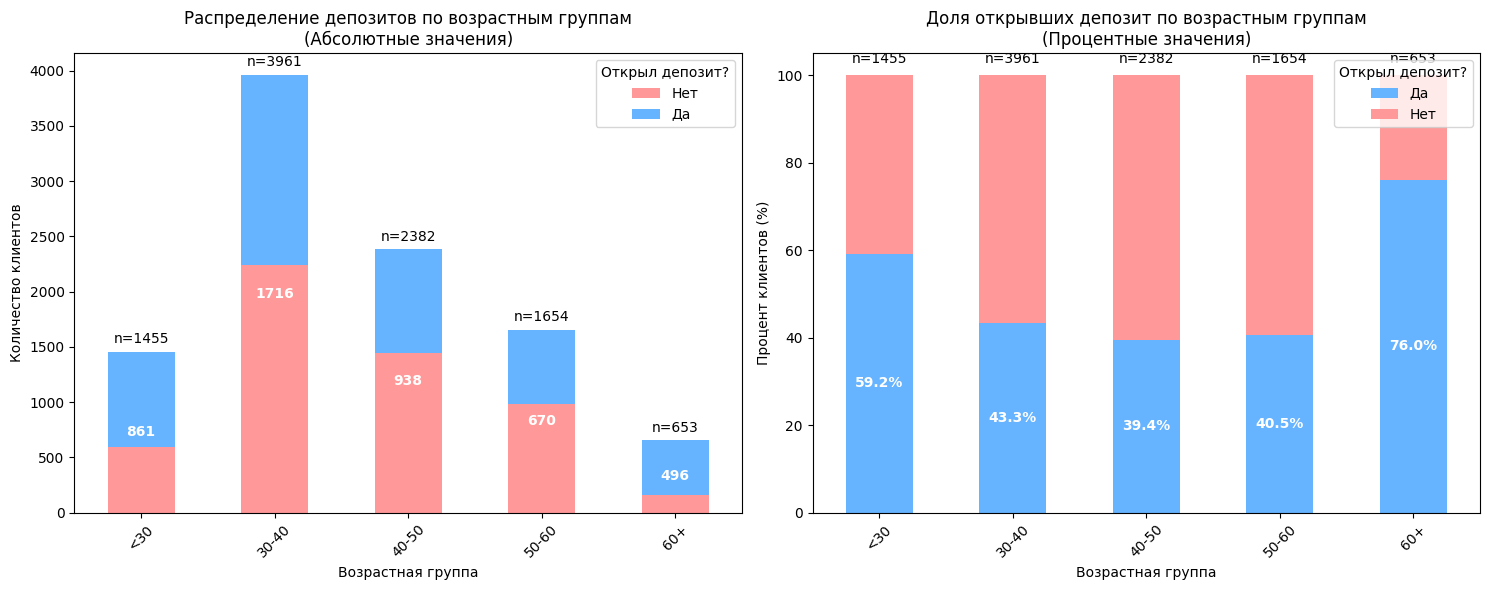


Процент открывших депозит по возрастным группам:
age_group
<30      59.2
30-40    43.3
40-50    39.4
50-60    40.5
60+      76.0
Name: yes, dtype: float64


In [27]:
# Создаем возрастные категории
age_bins = [0, 30, 40, 50, 60, float('inf')]
age_labels = ['<30', '30-40', '40-50', '50-60', '60+']
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Проверяем распределение по возрастным группам
print("Распределение клиентов по возрастным группам:")
print(df_filtered['age_group'].value_counts().sort_index())

# Строим комплексную визуализацию
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Stacked bar plot (Абсолютные значения)
age_deposit_counts = pd.crosstab(df_filtered['age_group'], df_filtered['deposit'])
age_deposit_counts.plot(kind='bar', stacked=True, ax=ax1, color=['#ff9999', '#66b3ff'])
ax1.set_title('Распределение депозитов по возрастным группам\n(Абсолютные значения)')
ax1.set_xlabel('Возрастная группа')
ax1.set_ylabel('Количество клиентов')
ax1.legend(title='Открыл депозит?', labels=['Нет', 'Да'])
ax1.tick_params(axis='x', rotation=45)

# Добавляем подписи на столбцы
for i, (index, row) in enumerate(age_deposit_counts.iterrows()):
    total = row.sum()
    ax1.text(i, total/2, f'{row["yes"]}', ha='center', va='center', fontweight='bold', color='white')
    ax1.text(i, total + 50, f'n={total}', ha='center', va='bottom', fontsize=10)

# 2. Процентный bar plot (Относительные значения)
age_deposit_percent = pd.crosstab(df_filtered['age_group'], df_filtered['deposit'], normalize='index') * 100
age_deposit_percent = age_deposit_percent[['yes', 'no']]  # Меняем порядок для stacked plot

age_deposit_percent.plot(kind='bar', stacked=True, ax=ax2, color=['#66b3ff', '#ff9999'])
ax2.set_title('Доля открывших депозит по возрастным группам\n(Процентные значения)')
ax2.set_xlabel('Возрастная группа')
ax2.set_ylabel('Процент клиентов (%)')
ax2.legend(title='Открыл депозит?', labels=['Да', 'Нет'], loc='upper right')
ax2.tick_params(axis='x', rotation=45)

# Добавляем проценты на столбцы
for i, (index, row) in enumerate(age_deposit_percent.iterrows()):
    yes_percent = row['yes']
    ax2.text(i, yes_percent/2, f'{yes_percent:.1f}%', ha='center', va='center', fontweight='bold', color='white')
    ax2.text(i, 102, f'n={age_deposit_counts.loc[index].sum()}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\nПроцент открывших депозит по возрастным группам:")
age_success_rate = pd.crosstab(df_filtered['age_group'], df_filtered['deposit'], normalize='index') * 100
print(age_success_rate['yes'].round(1))

In [28]:
# удалим переменную age
df_filtered = df_filtered.drop('age', axis=1)

#### Задания 9 и 10

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:  
* семейное положение;  
* уровень образования;  
* сфера занятости.

Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постараемся оформить диаграммы максимально наглядно и описать полученный результат.

К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

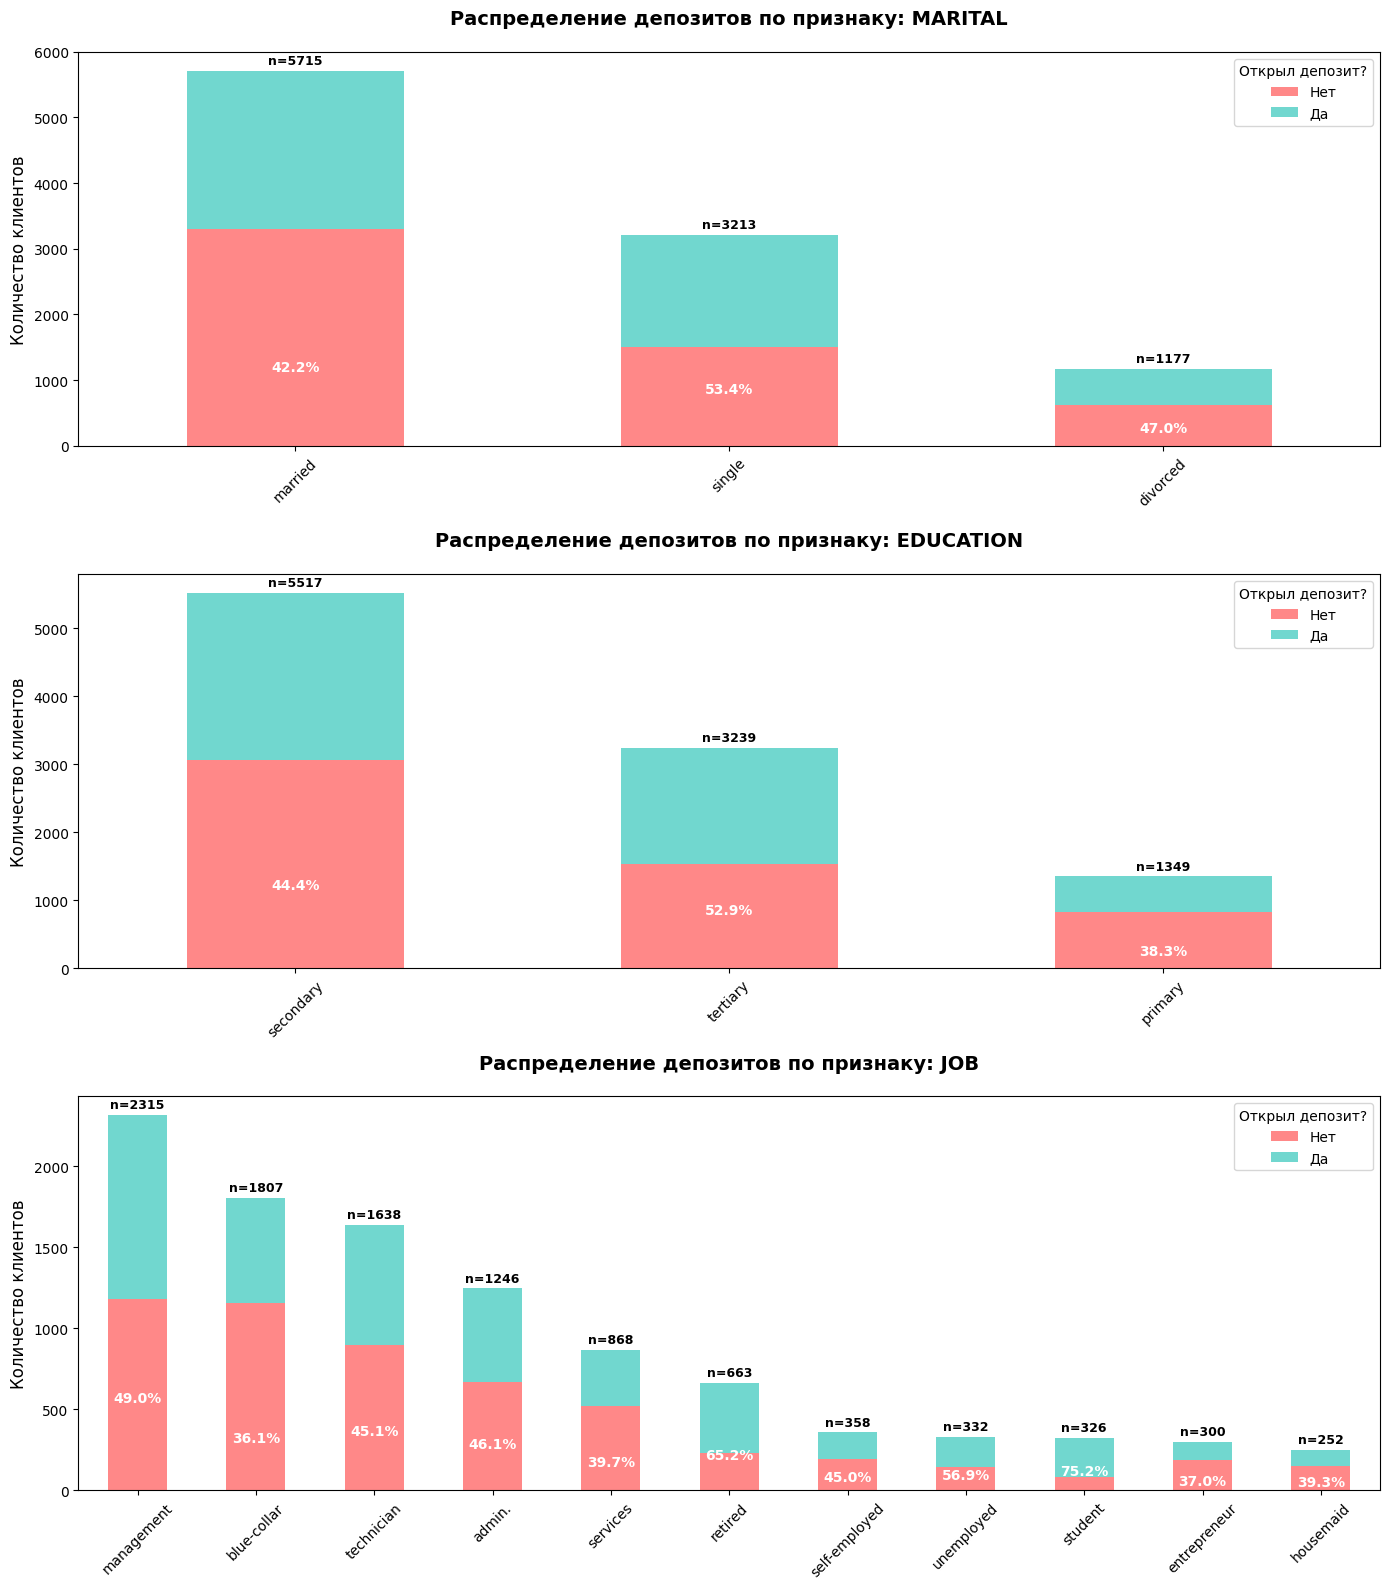

Процент успеха по категориям:

=== MARITAL ===
marital
single      53.4
divorced    47.0
married     42.2
Name: yes, dtype: float64

=== EDUCATION ===
education
tertiary     52.9
secondary    44.4
primary      38.3
Name: yes, dtype: float64

=== JOB ===
job
student          75.2
retired          65.2
unemployed       56.9
management       49.0
admin.           46.1
technician       45.1
self-employed    45.0
services         39.7
housemaid        39.3
entrepreneur     37.0
blue-collar      36.1
Name: yes, dtype: float64


In [29]:
# Создаем комплексную визуализацию для трех признаков
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# Список признаков для анализа
features = ['marital', 'education', 'job']

for i, feature in enumerate(features):
    # Создаем кросс-таблицу
    cross_tab = pd.crosstab(df_filtered[feature], df_filtered['deposit'])
    
    # Сортируем по убыванию общей численности группы
    cross_tab['total'] = cross_tab.sum(axis=1)
    cross_tab = cross_tab.sort_values('total', ascending=False)
    cross_tab = cross_tab.drop('total', axis=1)
    
    # Строим stacked bar plot
    ax = axes[i]
    cross_tab.plot(kind='bar', stacked=True, ax=ax, 
                   color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
    
    ax.set_title(f'Распределение депозитов по признаку: {feature.upper()}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Количество клиентов', fontsize=12)
    ax.legend(title='Открыл депозит?', labels=['Нет', 'Да'], loc='upper right')
    ax.tick_params(axis='x', rotation=45)
    
    # Добавляем проценты на график
    total_counts = cross_tab.sum(axis=1)
    for j, (idx, row) in enumerate(cross_tab.iterrows()):
        yes_count = row['yes']
        no_count = row['no']
        total = yes_count + no_count
        yes_percent = (yes_count / total) * 100
        
        # Добавляем абсолютные значения
        ax.text(j, total + max(total_counts)*0.01, f'n={total}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Добавляем проценты согласия
        ax.text(j, yes_count/2, f'{yes_percent:.1f}%', 
                ha='center', va='center', fontsize=10, 
                fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Дополнительная таблица с процентами успеха
print("Процент успеха по категориям:")
for feature in features:
    print(f"\n=== {feature.upper()} ===")
    success_rate = pd.crosstab(df_filtered[feature], df_filtered['deposit'], normalize='index') * 100
    print(success_rate['yes'].sort_values(ascending=False).round(1))

#### Задание 11

В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению. Представим результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можем сделать, исходя из полученных данных?

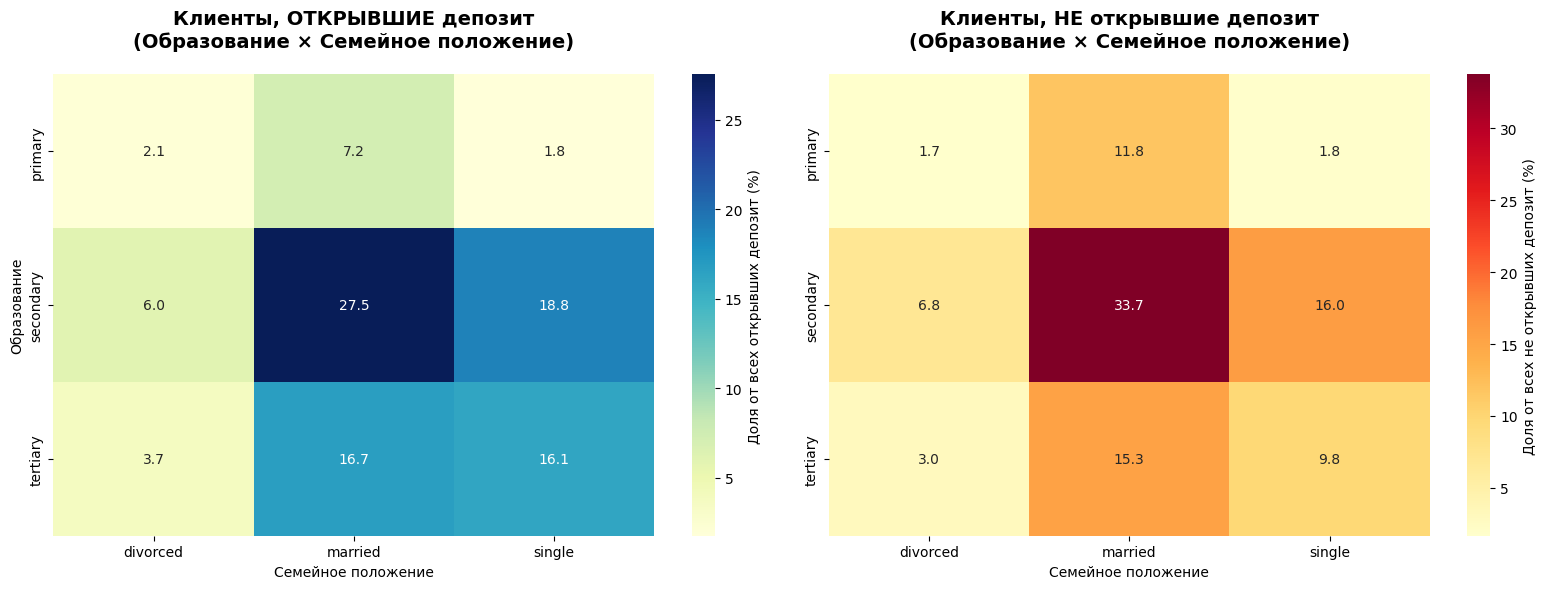

In [30]:
# Создаем сводные таблицы для каждой группы
pivot_yes = pd.crosstab(df_filtered[df_filtered['deposit'] == 'yes']['education'], 
                        df_filtered[df_filtered['deposit'] == 'yes']['marital'], 
                        normalize='all') * 100

pivot_no = pd.crosstab(df_filtered[df_filtered['deposit'] == 'no']['education'], 
                       df_filtered[df_filtered['deposit'] == 'no']['marital'], 
                       normalize='all') * 100

# Создаем визуализацию
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Тепловая карта для открывших депозит
sns.heatmap(pivot_yes, annot=True, fmt='.1f', cmap='YlGnBu', 
            cbar_kws={'label': 'Доля от всех открывших депозит (%)'}, ax=ax1)
ax1.set_title('Клиенты, ОТКРЫВШИЕ депозит\n(Образование × Семейное положение)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Семейное положение')
ax1.set_ylabel('Образование')

# Тепловая карта для не открывших депозит
sns.heatmap(pivot_no, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Доля от всех не открывших депозит (%)'}, ax=ax2)
ax2.set_title('Клиенты, НЕ открывшие депозит\n(Образование × Семейное положение)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Семейное положение')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## Часть 3: Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

* Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.

* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.  

* Надо отобрать признаки, которые мы будем использовать для обучения модели.

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: `education`.

Обработаем его с помощью метода `LabelEncoder`, используя метод без дополнительных настроек.

In [31]:
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Применяем кодирование к признаку education
df_filtered['education'] = label_encoder.fit_transform(df_filtered['education'])

# Проверим результат
print(df_filtered[['education']].value_counts())

education
1            5517
2            3239
0            1349
Name: count, dtype: int64


#### Задание 1

Найдём сумму получившихся значений для признака `education`.

In [32]:
education_sum = df_filtered['education'].sum()
print(f"Сумма значений признака education: {education_sum}")

Сумма значений признака education: 11995


Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [33]:
# Создаем mapping вручную для сохранения правильного порядка
age_group_mapping = {
    '<30': 0,
    '30-40': 1, 
    '40-50': 2,
    '50-60': 3,
    '60+': 4
}

# Применяем mapping к возрастным группам
df_filtered['age_group'] = df_filtered['age_group'].map(age_group_mapping)

# Проверим результат
print(df_filtered[['age_group']].value_counts())

age_group
1            3961
2            2382
3            1654
0            1455
4             653
Name: count, dtype: int64


Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную `deposit` таким образом, чтобы вместо `yes` она принимала значение 1, а вместо `no` — 0.

#### Задание 2 

Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной `deposit`. Ответ округлите до трёх знаков после точки-разделителя.

In [34]:
# Кодируем целевую переменную deposit
df_filtered['deposit'] = df_filtered['deposit'].map({'yes': 1, 'no': 0})

# Проверим результат
print(df_filtered[['deposit']].value_counts())

# вычисляем стандартное отклонение перекодированной целевой переменной
print(f"\nСтандартное отклонение целевой переменной deposit: {round(df_filtered['deposit'].std(), 3)}")

deposit
0          5424
1          4681
Name: count, dtype: int64

Стандартное отклонение целевой переменной deposit: 0.499


Сделаем то же самое для других бинарных переменных, которых у нас три:  
* `default`;  
* `housing`;  
* `loan`.

Все три мы будем модифицировать ровно так же: для слова `yes` мы возьмём в качестве значения 1, а для `no` — 0.

#### Задание 3

Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

In [35]:
# Кодируем целевую переменную default
df_filtered['default'] = df_filtered['default'].map({'yes': 1, 'no': 0})

# Кодируем целевую переменную housing
df_filtered['housing'] = df_filtered['housing'].map({'yes': 1, 'no': 0})

# Кодируем целевую переменную housing
df_filtered['loan'] = df_filtered['loan'].map({'yes': 1, 'no': 0})

# Проверим результат
print(df_filtered[['default']].value_counts())
print("+" * 60)
print(df_filtered[['housing']].value_counts())
print("+" * 60)
print(df_filtered[['loan']].value_counts())

# Вычисляем среднее арифметическое для каждой переменной
mean_default = df_filtered['default'].mean()
mean_housing = df_filtered['housing'].mean()
mean_loan = df_filtered['loan'].mean()

# Суммируем результаты и округляем до трех знаков после запятой
total_sum = round(mean_default + mean_housing + mean_loan, 3)

print(f"\nСумма средних значений: {total_sum}")


default
0          9939
1           166
Name: count, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
housing
0          5243
1          4862
Name: count, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
loan
0       8712
1       1393
Name: count, dtype: int64

Сумма средних значений: 0.635


#### Задание 4

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:  
* `job`;  
* `marital`;  
* `contact`;  
* `month`;  
* `poutcome`.

Создайте для них *dummy*-переменные и добавьте их в набор данных.

In [36]:
# Список номинальных переменных для преобразования
nominal_variables = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаем dummy-переменные для каждой номинальной переменной
for var in nominal_variables:
    dummies = pd.get_dummies(df_filtered[var], prefix=var, prefix_sep='_')
    df_filtered = pd.concat([df_filtered, dummies], axis=1)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   job                10105 non-null  object  
 1   marital            10105 non-null  object  
 2   education          10105 non-null  int32   
 3   default            10105 non-null  int64   
 4   balance            10105 non-null  float64 
 5   housing            10105 non-null  int64   
 6   loan               10105 non-null  int64   
 7   contact            10105 non-null  object  
 8   day                10105 non-null  int64   
 9   month              10105 non-null  object  
 10  duration           10105 non-null  int64   
 11  campaign           10105 non-null  int64   
 12  pdays              10105 non-null  int64   
 13  previous           10105 non-null  int64   
 14  poutcome           10105 non-null  object  
 15  deposit            10105 non-null  int64   
 16  age_group

In [37]:
# Удалим номинальные признаки
df_prom = df_filtered.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

df_prom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   education          10105 non-null  int32   
 1   default            10105 non-null  int64   
 2   balance            10105 non-null  float64 
 3   housing            10105 non-null  int64   
 4   loan               10105 non-null  int64   
 5   day                10105 non-null  int64   
 6   duration           10105 non-null  int64   
 7   campaign           10105 non-null  int64   
 8   pdays              10105 non-null  int64   
 9   previous           10105 non-null  int64   
 10  deposit            10105 non-null  int64   
 11  age_group          10105 non-null  category
 12  job_admin.         10105 non-null  bool    
 13  job_blue-collar    10105 non-null  bool    
 14  job_entrepreneur   10105 non-null  bool    
 15  job_housemaid      10105 non-null  bool    
 16  job_manag

#### Задания 5 и 6

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

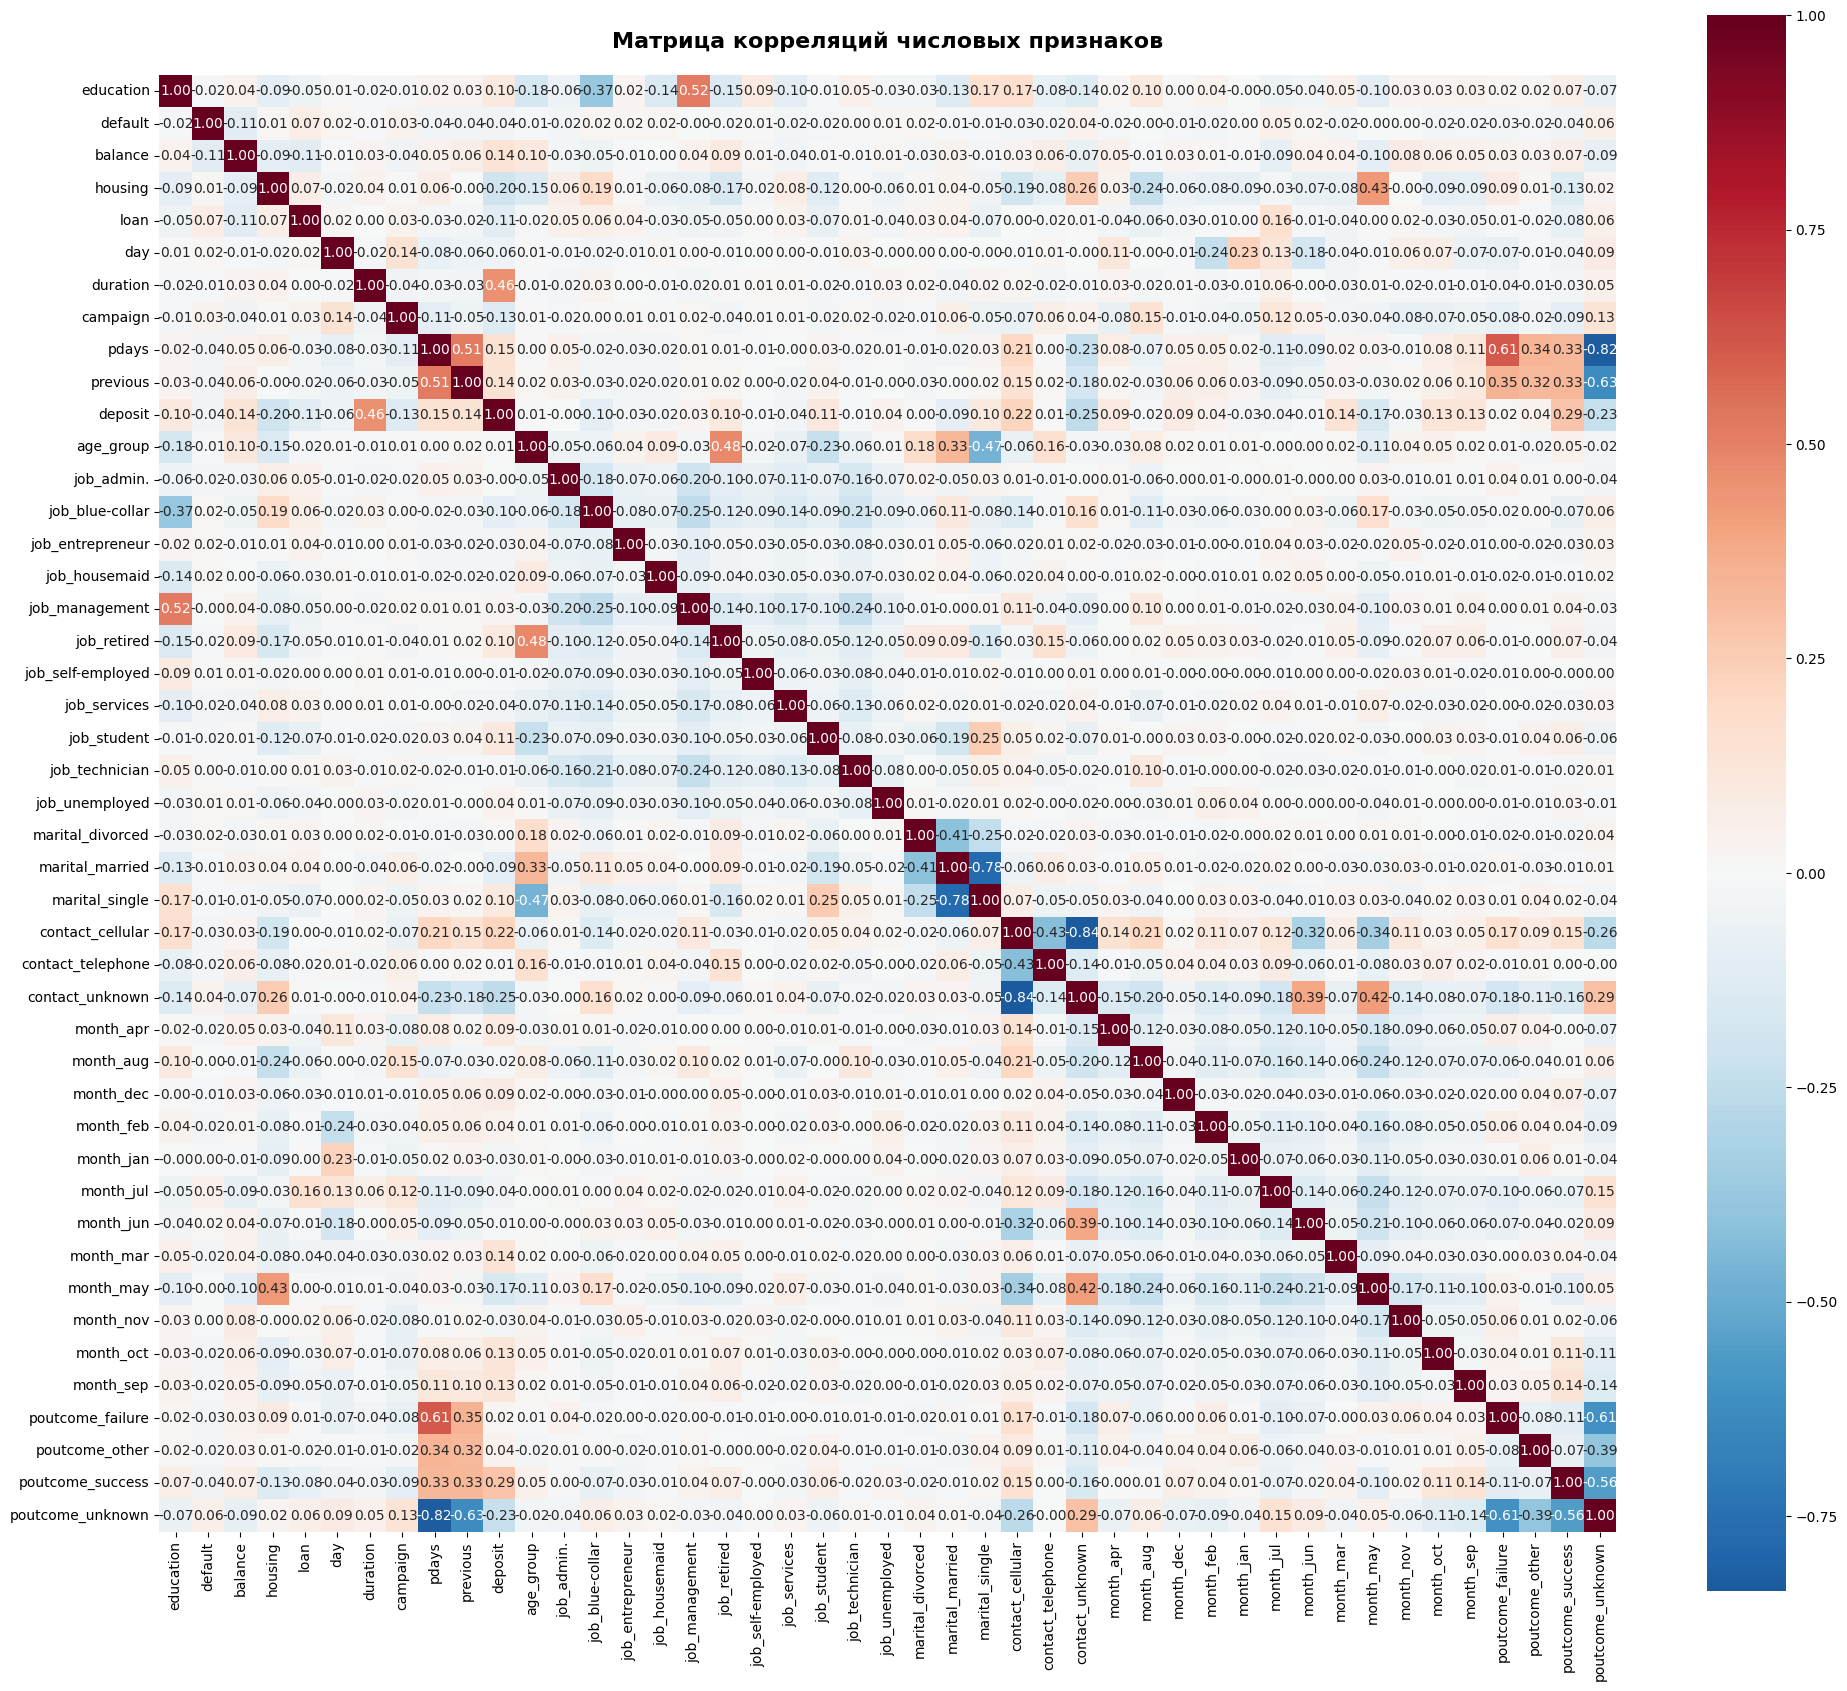

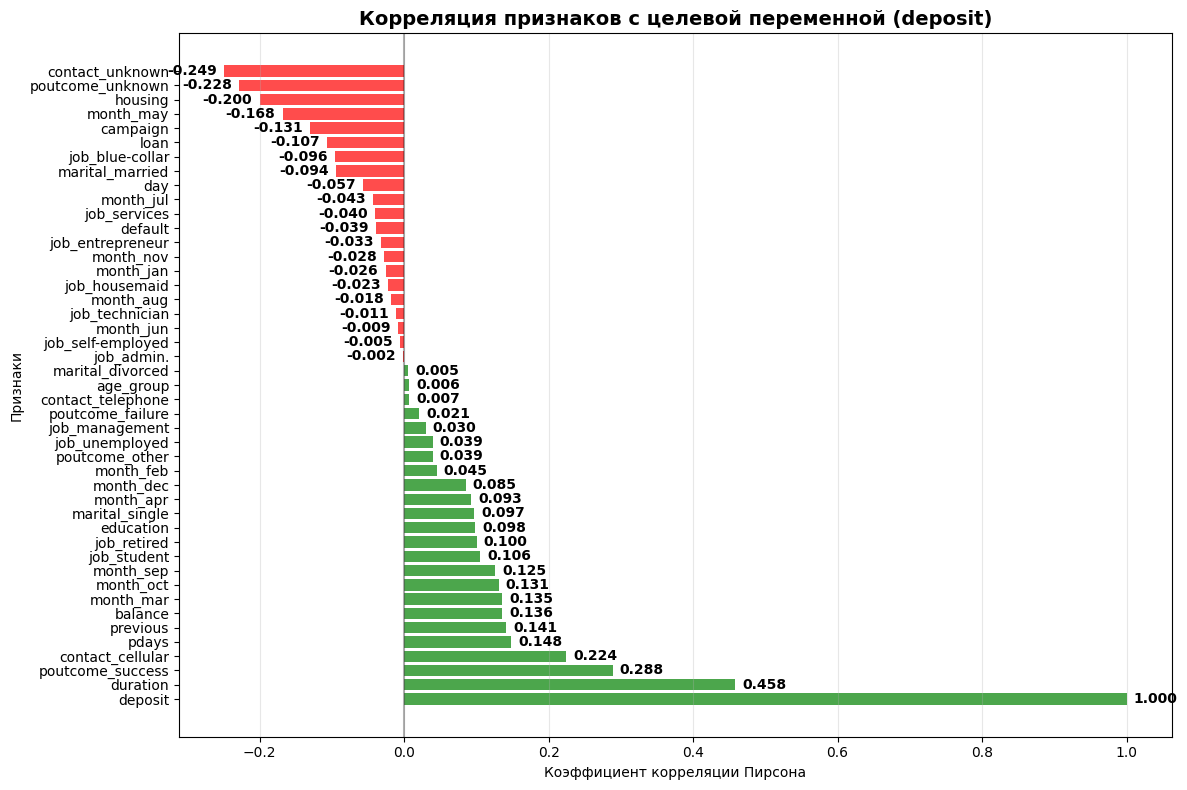

Пар признаков с корреляцией ≥ 0.9 не обнаружено.


In [38]:
# строим матрицу корреляции
correlation_matrix = df_prom.corr()

# Создаем тепловую карту
plt.figure(figsize=(20, 20))
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Маска для верхнего треугольника

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций числовых признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Анализ корреляций с целевой переменной
target_correlations = correlation_matrix['deposit'].sort_values(ascending=False)

# Строим столбчатую диаграмму для ранжированных коэффициентов корреляции
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in target_correlations]
bars = plt.barh(target_correlations.index, target_correlations.values, color=colors, alpha=0.7)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Коэффициент корреляции Пирсона')
plt.ylabel('Признаки')
plt.title('Корреляция признаков с целевой переменной (deposit)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, target_correlations.values):
    if value >= 0:
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', ha='left', fontweight='bold')
    else:
        plt.text(value - 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

# Находим пары признаков с корреляцией ≥ 0.9 (исключая диагональ)
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= 0.9:
            high_correlation_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

# Выводим результаты
if high_correlation_pairs:
    print("Обнаружены пары признаков с сильной мультиколлинеарностью (≥ 0.9):")
    print("-" * 70)
    for pair in high_correlation_pairs:
        print(f"{pair[0]} ↔ {pair[1]}: {pair[2]:.4f}")
else:
    print("Пар признаков с корреляцией ≥ 0.9 не обнаружено.")


#### Задания 7 и 8

Теперь нам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр `random_state = 42`, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

Каким получился размер тестовой выборки?

Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [39]:
# Определяем целевую переменную и предикторы
X = df_prom.drop('deposit', axis=1)  # Все признаки кроме целевой
y = df_prom['deposit']  # Целевая переменная

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42,
    stratify=y  # Сохраняем соотношение классов
)

# Анализируем результаты
print("Размеры выборок:")
print(f"Обучающая выборка (X_train): {X_train.shape}")
print(f"Тестовая выборка (X_test): {X_test.shape}")
print(f"Обучающая целевая (y_train): {y_train.shape}")
print(f"Тестовая целевая (y_test): {y_test.shape}")

# Вычисляем среднее значение целевой переменной на тестовой выборке
test_target_mean = round(y_test.mean(), 2)

print(f"\nСреднее значение целевой переменной на тестовой выборке: {test_target_mean}")

Размеры выборок:
Обучающая выборка (X_train): (6770, 44)
Тестовая выборка (X_test): (3335, 44)
Обучающая целевая (y_train): (6770,)
Тестовая целевая (y_test): (3335,)

Среднее значение целевой переменной на тестовой выборке: 0.46


#### Задание 9

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью `SelectKBest` отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр `score_func = f_classif`.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

Отобрано признаков: 15

Топ-15 отобранных признаков (ранжированы по F-score):
             Признак      F-score
3           duration  1839.078214
13  poutcome_success   628.351616
8    contact_unknown   427.557659
14  poutcome_unknown   373.006765
7   contact_cellular   350.501992
1            housing   301.264198
10         month_may   183.875989
6           previous   153.923796
5              pdays   148.749979
4           campaign   139.486664
12         month_sep   130.230009
11         month_oct   125.319693
9          month_mar   114.759591
0            balance   114.356404
2               loan    88.585218


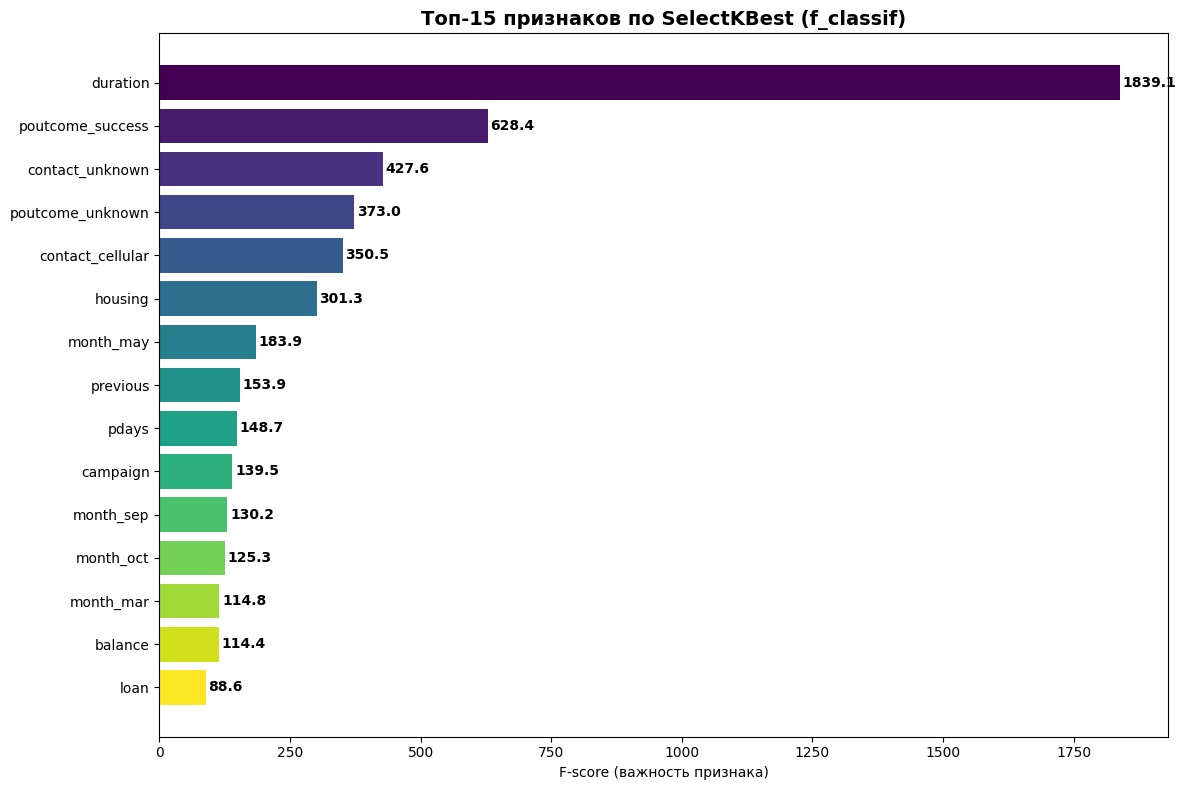


Отобранные признаки готовы для использования в модели!
Размер обучающей выборки после отбора: (6770, 15)
Размер тестовой выборки после отбора: (3335, 15)


In [40]:
# Применяем SelectKBest для отбора 15 лучших признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Получаем имена отобранных признаков
selected_features = X_train.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]

# Создаем DataFrame с результатами отбора
feature_ranking = pd.DataFrame({
    'Признак': selected_features,
    'F-score': scores
}).sort_values('F-score', ascending=False)

print(f"Отобрано признаков: {X_train_sel.shape[1]}")
print("\nТоп-15 отобранных признаков (ранжированы по F-score):")
print(feature_ranking)

# Визуализируем результаты отбора
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_ranking)))
bars = plt.barh(feature_ranking['Признак'], feature_ranking['F-score'], color=colors)

plt.xlabel('F-score (важность признака)')
plt.title('Топ-15 признаков по SelectKBest (f_classif)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Чтобы самый важный признак был сверху

# Добавляем значения на столбцы
for bar, score in zip(bars, feature_ranking['F-score']):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{score:.1f}', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Сохраняем отобранные признаки для дальнейшего использования
print("\nОтобранные признаки готовы для использования в модели!")
print(f"Размер обучающей выборки после отбора: {X_train_sel.shape}")
print(f"Размер тестовой выборки после отбора: {X_test_sel.shape}")

#### Задание 10

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать` min-max`-нормализацию.

Помните, что нормализация требуется для предикторов, а не для целевой переменной.

Нормализуйте предикторы в обучающей и тестовой выборках.

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [41]:
# Создаем и настраиваем MinMaxScaler на обучающих данных
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train_sel)
X_test_norm = scaler.transform(X_test_sel)

# Преобразуем обратно в DataFrame для удобства
X_train_norm_df = pd.DataFrame(X_train_norm, columns=selected_features)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=selected_features)

# Проверяем результаты нормализации
print("Статистики ПЕРВОГО признака до нормализации:")
print(f"Обучающая выборка: min={X_train_sel[:, 0].min():.2f}, max={X_train_sel[:, 0].max():.2f}")
print(f"Тестовая выборка: min={X_test_sel[:, 0].min():.2f}, max={X_test_sel[:, 0].max():.2f}")

print("\nСтатистики ПЕРВОГО признака после нормализации:")
print(f"Обучающая выборка: min={X_train_norm[:, 0].min():.2f}, max={X_train_norm[:, 0].max():.2f}")
print(f"Тестовая выборка: min={X_test_norm[:, 0].min():.2f}, max={X_test_norm[:, 0].max():.2f}")

# Вычисляем среднее арифметическое для первого предиктора в тестовой выборке
first_predictor_mean = round(X_test_norm[:, 0].mean(), 2)

print(f"\nСреднее арифметическое первого предиктора в тестовой выборке: {first_predictor_mean}")

# Дополнительная проверка: убедимся, что все значения в диапазоне [0, 1]
print(f"\nПроверка диапазона для всей тестовой выборки:")
print(f"Минимальное значение: {X_test_norm.min():.4f}")
print(f"Максимальное значение: {X_test_norm.max():.4f}")

Статистики ПЕРВОГО признака до нормализации:
Обучающая выборка: min=-2049.00, max=4063.00
Тестовая выборка: min=-1944.00, max=4062.00

Статистики ПЕРВОГО признака после нормализации:
Обучающая выборка: min=0.00, max=1.00
Тестовая выборка: min=0.02, max=1.00

Среднее арифметическое первого предиктора в тестовой выборке: 0.47

Проверка диапазона для всей тестовой выборки:
Минимальное значение: 0.0000
Максимальное значение: 1.0000


## Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать `'sag'`, в качестве значения параметра `random_state` возьмём число 42 и запустим 1000 итераций.

Оценим качество модели на тестовой выборке.

Для получившейся модели вычислим значение `accuracy` на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [42]:
# Создаем и обучаем модель логистической регрессии
logreg = LogisticRegression(
    random_state=42,    # для воспроизводимости результатов
    max_iter=1000,      # количество итераций
    solver='sag'        # алгоритм оптимизации
)

# Обучаем модель на нормализованных данных
logreg.fit(X_train_norm_df, y_train)

# Делаем предсказания на тестовой выборке
y_pred_lr = logreg.predict(X_test_norm_df)

# Вычисляем accuracy
accuracy_lr = round(accuracy_score(y_test, y_pred_lr), 2)

print("Результаты логистической регрессии:")
print(f"Accuracy на тестовой выборке: {accuracy_lr}")

Результаты логистической регрессии:
Accuracy на тестовой выборке: 0.8


### Задания 2,3,4

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:  
* `criterion` = `'entropy'`;  
* `random_state` = 42.

Остальные параметры оставьте по умолчанию.

Переберём различные максимальные глубины деревьев и найдём глубину дерева, для которой будет максимальное значение метрики `accuracy`, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

Какое наибольшее значение `accuracy` у вас получилось?

Какую максимальную глубину дерева вы задали?

In [43]:
# Создаем и обучаем дерево решений
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучаем модель на нормализованных данных
tree.fit(X_train_norm_df, y_train)

# Делаем предсказания на обучающей и тестовой выборках
y_train_pred_dt = tree.predict(X_train_norm_df)
y_test_pred_dt = tree.predict(X_test_norm_df)

# Вычисляем accuracy
train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)

print(f"Accuracy на обучающей выборке: {train_acc_dt}")
print(f"Accuracy на тестовой выборке: {test_acc_dt}")

Accuracy на обучающей выборке: 0.9997045790251108
Accuracy на тестовой выборке: 0.7535232383808096


In [45]:
# Будем перебирать глубину дерева от 1 до 30
max_depths_dt = range(1, 31)
train_accuracies_dt = []
test_accuracies_dt = []

print("Поиск оптимальной глубины дерева:")
print("Глубина | Accuracy (train) | Accuracy (test) | Разница")
print("-" * 55)

best_accuracy_dt = 0
best_depth_dt = 0

for depth in max_depths_dt:
    # Создаем и обучаем дерево
    tree = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=depth,
        random_state=42
    )
    tree.fit(X_train_norm_df, y_train)
    
    # Предсказания на обучающей и тестовой выборках
    y_train_pred_dt = tree.predict(X_train_norm_df)
    y_test_pred_dt = tree.predict(X_test_norm_df)
    
    # Вычисляем accuracy
    train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
    test_acc_dt = accuracy_score(y_test, y_test_pred_dt)
    
    train_accuracies_dt.append(train_acc_dt)
    test_accuracies_dt.append(test_acc_dt)
    
    diff = train_acc_dt - test_acc_dt  # Разница как показатель переобучения
    
    print(f"{depth:7} | {train_acc_dt:.4f}          | {test_acc_dt:.4f}         | {diff:.4f}")
    
    # Ищем лучшую accuracy на тесте
    if test_acc_dt > best_accuracy_dt:
        best_accuracy_dt = test_acc_dt
        best_depth_dt = depth

print(f"\nРезультаты:")
print(f"Наилучшая accuracy на тестовой выборке: {best_accuracy_dt:.4f}")
print(f"Оптимальная глубина дерева: {best_depth_dt}")

# Анализ переобучения
overfitting_start = None
for i in range(1, len(max_depths_dt)):
    if train_accuracies_dt[i] > test_accuracies_dt[i] + 0.05:  # Порог переобучения
        overfitting_start = max_depths_dt[i]
        break

if overfitting_start:
    print(f"Переобучение начинается с глубины: {overfitting_start}")
else:
    print("Явного переобучения не обнаружено в tested диапазоне")

Поиск оптимальной глубины дерева:
Глубина | Accuracy (train) | Accuracy (test) | Разница
-------------------------------------------------------
      1 | 0.7115          | 0.7064         | 0.0051
      2 | 0.7288          | 0.7178         | 0.0110
      3 | 0.7758          | 0.7703         | 0.0055
      4 | 0.7758          | 0.7703         | 0.0055
      5 | 0.8038          | 0.7943         | 0.0095
      6 | 0.8164          | 0.8042         | 0.0122
      7 | 0.8232          | 0.8045         | 0.0187
      8 | 0.8316          | 0.8042         | 0.0274
      9 | 0.8396          | 0.7976         | 0.0420
     10 | 0.8542          | 0.8015         | 0.0527
     11 | 0.8671          | 0.8003         | 0.0668
     12 | 0.8774          | 0.7964         | 0.0810
     13 | 0.8870          | 0.7952         | 0.0918
     14 | 0.8993          | 0.7922         | 0.1071
     15 | 0.9103          | 0.7793         | 0.1310
     16 | 0.9216          | 0.7769         | 0.1447
     17 | 0.9310       

`Accuracy` у дерева решений с подбором глубины дерева гораздо лучше чем без подбора. В свою очередь метрика совсем незначительно улучшилась по сравнению с логистической регрессией.

### Задание 5

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуем оптимизацию гиперпараметров с помощью `GridSearch`, перебрав следующие параметры:  
* `'min_samples_split'`: [2, 5, 7, 10];  
* `'max_depth'`:[3,5,7].

Оценим метрику $F_1$ на тестовой выборке для наилучшей комбинации перебираемых параметров. В качестве ответа впишите значение метрики.

In [47]:
# Определяем параметры для перебора
param_grid_dt = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создаем модель дерева решений
tree = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Создаем GridSearchCV объект с F1-score в качестве метрики
f1_scorer_dt = make_scorer(f1_score)
grid_search_dt = GridSearchCV(
    estimator=tree,
    param_grid=param_grid_dt,
    scoring=f1_scorer_dt,  # Используем F1-score как метрику оптимизации
    cv=5,               # 5-кратная кросс-валидация
    n_jobs=-1,          # Используем все доступные ядра процессора
    verbose=1           # Выводим прогресс
)

# Запускаем поиск по сетке параметров
print("Запуск GridSearchCV...")
grid_search_dt.fit(X_train_norm_df, y_train)

# Выводим результаты
print("\nЛучшие параметры:", grid_search_dt.best_params_)
print("Лучший F1-score (кросс-валидация):", grid_search_dt.best_score_)

# Оцениваем на тестовой выборке
best_tree_dt = grid_search_dt.best_estimator_
y_pred_dt = best_tree_dt.predict(X_test_norm_df)
test_f1_dt = f1_score(y_test, y_pred_dt)

print(f"F1-score на тестовой выборке: {test_f1_dt:.4f}")


Запуск GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
Лучший F1-score (кросс-валидация): 0.79507495752203
F1-score на тестовой выборке: 0.7837


## Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Мы уже смогли обучить несложные модели, и теперь пришло время усложнить их, а также посмотреть, улучшится ли результат (если да, то насколько). Мы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес.

Обучим случайный лес со следующими параметрами:  
* `n_estimators` = 100;  
* `criterion` = 'gini';  
* `min_samples_leaf` = 5;  
* `max_depth` = 10;  
* `random_state` = 42.

Оценим метрики `accuracy` и `recall` для построенной модели на тестовой выборке. В качестве ответов введём значения метрик.

In [48]:
# Создаем и обучаем модель случайного леса
rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Используем все ядра процессора для ускорения
)

print("Обучение случайного леса...")
rf.fit(X_train_norm_df, y_train)

# Делаем предсказания на тестовой выборке
y_pred_rf = rf.predict(X_test_norm_df)

# Вычисляем метрики
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print(f"Accuracy на тестовой выборке: {accuracy_rf:.4f}")
print(f"Recall на тестовой выборке: {recall_rf:.4f}")


Обучение случайного леса...
Accuracy на тестовой выборке: 0.8273
Recall на тестовой выборке: 0.8304


Как видим метрики у случайного леса повысились по сравнению с метриками логистической регрессии и дерева решений.

### Задания 2 и 3

Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью **градиентного бустинга**. Используем градиентный бустинг для решения задачи классификации, задав для него следующие параметры:  
* `learning_rate` = 0.05;  
* `n_estimators` = 300;  
* `min_samples_leaf` = 5;  
* `max_depth` = 5;  
* `random_state` = 42.

Для построенной модели оценим метрику $F_1$ на тестовой выборке. В качестве ответа впишим значение метрики. 

Какая модель даёт более качественный прогноз (если посмотреть известные вам метрики в целом)?

In [49]:
# Создаем и обучаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

print("Обучение градиентного бустинга...")
gb.fit(X_train_norm_df, y_train)

# Делаем предсказания на тестовой выборке
y_test_pred_gb = gb.predict(X_test_norm_df)

# Вычисляем метрики
f1_gb = f1_score(y_test, y_test_pred_gb)
accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
recall_gb = recall_score(y_test, y_test_pred_gb)
precision_gb = precision_score(y_test, y_test_pred_gb)

print(f"F1-score на тестовой выборке: {f1_gb:.4f}")
print(f"Accuracy на тестовой выборке: {accuracy_gb:.4f}")
print(f"Recall на тестовой выборке: {recall_gb:.4f}")
print(f"Precision на тестовой выборке: {precision_gb:.4f}")

# Сравнение со случайным лесом
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\nСравнение с случайным лесом:")
print(f"F1-score: GB = {f1_gb:.4f} vs RF = {f1_rf:.4f}")
print(f"Accuracy: GB = {accuracy_gb:.4f} vs RF = {accuracy_rf:.4f}")

Обучение градиентного бустинга...
F1-score на тестовой выборке: 0.8143
Accuracy на тестовой выборке: 0.8240
Recall на тестовой выборке: 0.8330
Precision на тестовой выборке: 0.7964

Сравнение с случайным лесом:
F1-score: GB = 0.8143 vs RF = 0.8167
Accuracy: GB = 0.8240 vs RF = 0.8273


Как видим, градиентный бустинг не улучшил метрики для наших данных.

### Задание 4

Мы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

В этом задании нам необходимо использовать **стекинг**, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставим те же, что были в наших алгоритмах в предыдущих заданиях.

Для построенной модели оценим метрику `precision` на тестовой выборке. В качестве ответа впишим значение метрики.

In [50]:
# Определяем базовые модели
base_models = [
    ('decision_tree', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=7,
        random_state=42
    )),
    ('logistic_regression', LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='sag'
    )),
    ('gradient_boosting', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

# Создаем стекинг-ансамбль с логистической регрессией в качестве метамодели
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5,  # 5-кратная кросс-валидация для стекинга
    n_jobs=-1
)

print("Обучение стекинг-ансамбля...")
stacking_model.fit(X_train_norm_df, y_train)

# Делаем предсказания на тестовой выборке
y_pred_stack = stacking_model.predict(X_test_norm_df)

# Вычисляем precision
precision_stack = precision_score(y_test, y_pred_stack)

print(f"Precision на тестовой выборке: {precision_stack:.4f}")


Обучение стекинг-ансамбля...
Precision на тестовой выборке: 0.8117


Мы смогли улучшить метрику `Precision` применив стэкинг! И это замечательно.

### Задание 5

Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Топ-10 самых важных признаков:
             Признак  Важность
3           duration  0.514145
13  poutcome_success  0.118988
8    contact_unknown  0.078947
0            balance  0.061918
5              pdays  0.055429
1            housing  0.050464
9          month_mar  0.027025
11         month_oct  0.019516
4           campaign  0.018008
12         month_sep  0.015613


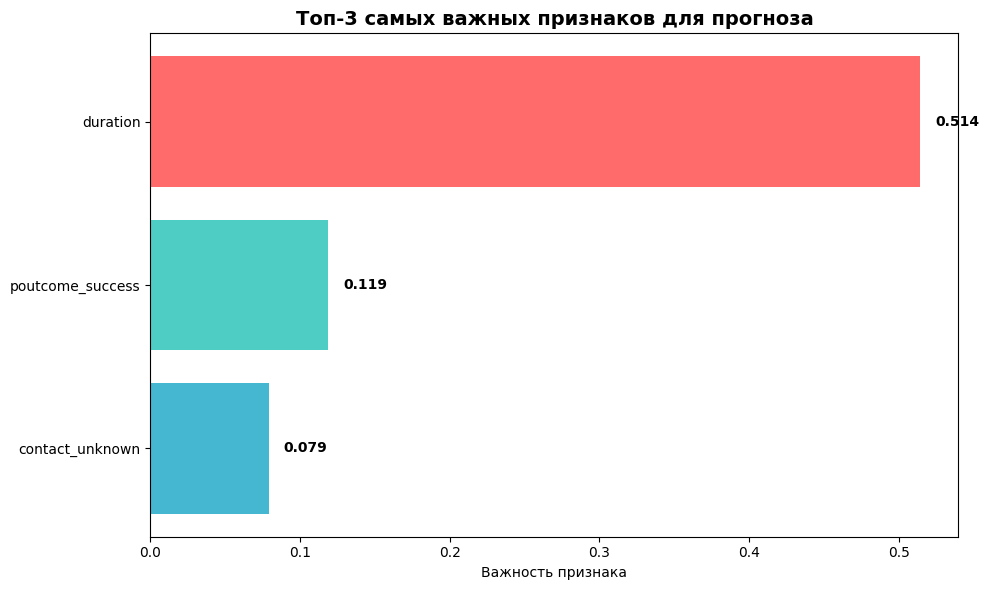

In [51]:
# Анализируем важность признаков из лучшей модели (градиентный бустинг)
feature_importance_gb = pd.DataFrame({
    'Признак': selected_features,
    'Важность': gb.feature_importances_
}).sort_values('Важность', ascending=False)

print("Топ-10 самых важных признаков:")
print(feature_importance_gb.head(10))

# Визуализируем топ-3 признака
top_3_features = feature_importance_gb.head(3)
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.barh(top_3_features['Признак'], top_3_features['Важность'], color=colors)
plt.xlabel('Важность признака')
plt.title('Топ-3 самых важных признаков для прогноза', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Добавляем значения на столбцы
for bar, importance in zip(bars, top_3_features['Важность']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

### Задания 6,7,8

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи `GridSearch`. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк **Optuna**. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:  
* `n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)`;  
* `max_depth = trial.suggest_int('max_depth', 10, 30, 1)`;  
* `min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)`.

Введите значение метрики $F_1$ на тестовой выборке.

Введите значение метрики `accuracy` на тестовой выборке.

Улучшился ли результат по сравнению с предыдущими моделями?

In [52]:
# Определяем функцию objective для Optuna
def objective(trial):
    # Предлагаемые параметры для перебора
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель с предложенными параметрами
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Используем кросс-валидацию для оценки качества
    score = cross_val_score(model, X_train_norm_df, y_train, 
                           cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score

# Создаем study и запускаем оптимизацию
study = optuna.create_study(direction='maximize')
print("Запуск Optuna optimization...")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Выводим результаты оптимизации
print("\nЛучшие параметры:", study.best_params)
print("Лучший F1-score (кросс-валидация):", study.best_value)

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_norm_df, y_train)

# Оценка на тестовой выборке
y_pred_optuna = best_rf.predict(X_test_norm_df)
f1_optuna = f1_score(y_test, y_pred_optuna)
accuracy_optuna = accuracy_score(y_test, y_pred_optuna)

print(f"\nРезультаты на тестовой выборке:")
print(f"F1-score: {f1_optuna:.4f}")
print(f"Accuracy: {accuracy_optuna:.4f}")

# Сравнение с предыдущей моделью случайного леса
y_pred_prev_rf = rf.predict(X_test_norm_df)
f1_prev = f1_score(y_test, y_pred_prev_rf)
accuracy_prev = accuracy_score(y_test, y_pred_prev_rf)

print(f"\nСравнение с предыдущей моделью Random Forest:")
print(f"F1-score: {f1_prev:.4f} → {f1_optuna:.4f} ({f1_optuna - f1_prev:+.4f})")
print(f"Accuracy: {accuracy_prev:.4f} → {accuracy_optuna:.4f} ({accuracy_optuna - accuracy_prev:+.4f})")

# Сравнение с градиентным бустингом
print(f"\nСравнение с Gradient Boosting:")
print(f"F1-score: GB = {f1_gb:.4f} vs Optuna RF = {f1_optuna:.4f}")
print(f"Accuracy: GB = {accuracy_gb:.4f} vs Optuna RF = {accuracy_optuna:.4f}")

[I 2025-09-22 19:12:24,548] A new study created in memory with name: no-name-fd23a241-3a2b-4700-b2f0-4ed114136465


Запуск Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-22 19:12:27,498] Trial 0 finished with value: 0.8178682954152252 and parameters: {'n_estimators': 138, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8178682954152252.
[I 2025-09-22 19:12:28,749] Trial 1 finished with value: 0.8190581986254898 and parameters: {'n_estimators': 132, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8190581986254898.
[I 2025-09-22 19:12:30,277] Trial 2 finished with value: 0.8190980422204042 and parameters: {'n_estimators': 184, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8190980422204042.
[I 2025-09-22 19:12:31,176] Trial 3 finished with value: 0.820565528382564 and parameters: {'n_estimators': 115, 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.820565528382564.
[I 2025-09-22 19:12:32,049] Trial 4 finished with value: 0.8226631714328845 and parameters: {'n_estimators': 111, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.82266

## Итоги

Для решения задачи классификации в данном проекте хорошо себя показали модели бустинга и стэкинга, а также модель случайного леса с подобранными гиперпараметрами методом *Optuna*.

В ходе исследования выделили три наиболее важных фактора (факторы перечислены по мере убывания важности):  
* **duration (продолжительность контакта в секундах)** - оптимальная продолжительность контакта находится в диапазоне - от 240 до 340 секунд.  
* **poutcome_success (результат прошлой маркетинговой кампании) - success (успех)**.  
* **contact_unknown (тип контакта с клиентом)** - **unknown(неизвестный)**.

Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит (со стороны клиента) играют внешние факторы, такие как упомянутые ранее, например, продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д.

Вторичны факторы индивидуальные для конкретного клиента:  
* Сфера занятости (**job_student**, **job_retired**) - целевая аудитория это студенты и пенсионеры.  
* **age_group** (возрастная группа) - потенциальные группы - младше 31 и старше 60 (подтверждает результаты строчки выше).  
* **marital** (семейное положение) - клиенты не состоящие в браке охотнее открывают депозит.  
* **month** (месяц контакта с клиентом) - наиболее благоприятный месяц для открытия депозита, когда стоит увеличить активность контактов с клиентами - это декабрь, наименее результативный - май.

Другие факторы тоже влияют на решение клиента в меньшей степени, но их тоже необходимо учитывать при планировании будущей маркетинговой кампании.

Также стоит упомянуть о лояльности клиентов - как показали исследования, клиенты открывшие депозиты в результате прошлой маркетинговой кампании, охотно соглашаются и в новой кампании - данную группу необходимо использовать в будущих маркетинговых кампаниях и сохранять их лояльность. При планировании новой маркетинговой кампании необходимо обязательно более тщательно подходить к вопросу выбора контакта с клиентом - в данной кампании порядка 21% вид контакта неизвестен, данный факт касается также и poutcome (результат прошлой маркетинговой кампании).